{'python': '3.11.13', 'numpy': '2.2.6', 'pandas': '2.3.1', 'sklearn': '1.7.1', 'xgboost': '3.0.3', 'matplotlib': '3.10.5'}
=== Block 1 — Sanity Snapshot ===
Date range: 2018-01-01 → 2018-05-09  (129 days)
Duplicate dates (before aggregation): 0
Missing days (calendar gaps): 0  (0.00%)
Zero-revenue days: 0  (0.00%)


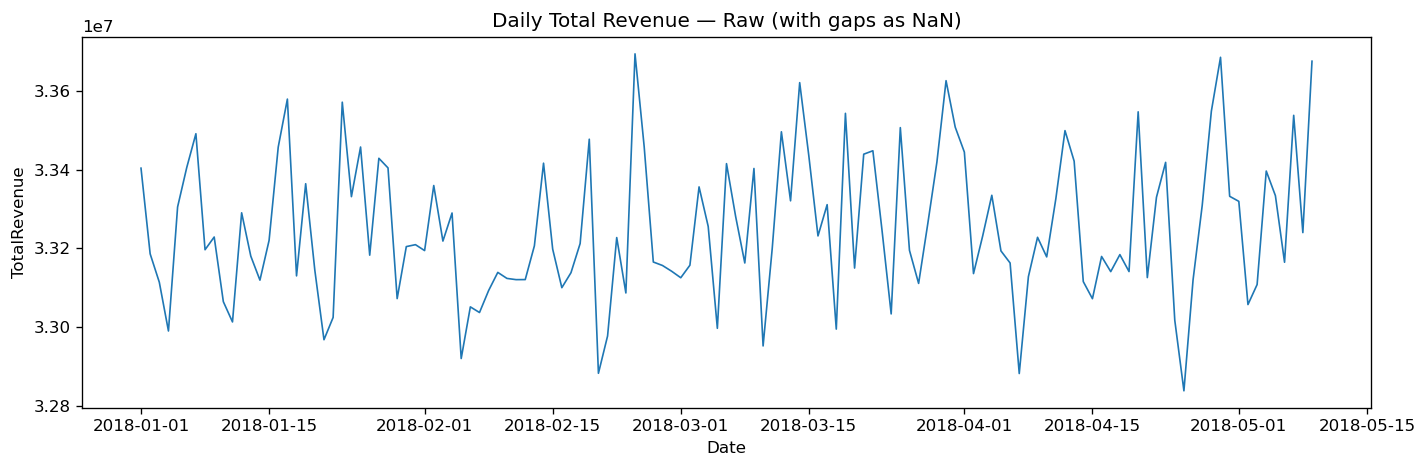

[Timing] Block 1 completed in 0.19s
=== Block 2 — Snapshot ===
Shape after warm-up drop: (101, 19)
=== Block 2B — SAFE Enrichment Snapshot ===
            txcount_lag_1  txcount_lag_7  avgticket_lag_1  avgticket_lag_7  \
SalesDate                                                                    
2018-01-30          51597           <NA>       640.971789              NaN   
2018-01-31          51973           <NA>       638.877281              NaN   
2018-02-01          51772           <NA>       641.452802              NaN   

            txcount_roll_mean_7  txcount_roll_mean_14  avgticket_roll_mean_7  \
SalesDate                                                                      
2018-01-30         51597.000000          51597.000000             640.971789   
2018-01-31         51785.000000          51785.000000             639.924535   
2018-02-01         51780.666667          51780.666667             640.433957   

            avgticket_roll_mean_14  
SalesDate                   

In [1]:
# ============================================
# Notebook 5 — Sales Forecasting (V2)
# ============================================

# -------------------------
# Block 0 — Setup & Config
# -------------------------
import os, time, json, warnings, itertools, math, shutil
from dataclasses import dataclass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
plt.rcParams["figure.dpi"] = 120

# Paths
DATA_DIR_IN  = Path("clean") / "model_input"
FORECAST_DIR = Path("clean") / "forecast"
PLOTS_DIR    = FORECAST_DIR / "plots"
PRED_DIR     = FORECAST_DIR / "predictions"
MODEL_DIR    = FORECAST_DIR / "models"
REPORT_DIR   = FORECAST_DIR / "report"

for d in [PLOTS_DIR, PRED_DIR, MODEL_DIR, REPORT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

PATH_SALES_DAILY = DATA_DIR_IN / "model_input_sales.parquet"                # daily time series
PATH_TX          = DATA_DIR_IN / "model_input_sales_transactions.parquet"   # transaction-level input

# Common helpers
EPS = 1e-9
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))
def mae(y_true, y_pred):  return float(np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))))
def mape(y_true, y_pred, eps=EPS):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return float(np.mean(np.abs((y_true - y_pred)/denom)) * 100.0)
def wape(y_true, y_pred, eps=EPS):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sum(np.abs(y_true - y_pred)) / max(np.sum(np.abs(y_true)), eps))
# --- Versions snapshot (reproducibility) ---
import sys, sklearn, xgboost, matplotlib as mpl
print({
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "sklearn": sklearn.__version__,
    "xgboost": xgboost.__version__,
    "matplotlib": mpl.__version__,
})

# ============================================
# Block 1 — Load & Sanity Snapshot
# ============================================
t0 = time.time()
assert PATH_SALES_DAILY.exists(), f"Input not found: {PATH_SALES_DAILY}"
df = pd.read_parquet(PATH_SALES_DAILY)

required_cols = {"SalesDate", "TotalRevenue"}
missing_cols = required_cols - set(df.columns)
assert not missing_cols, f"Missing required columns: {missing_cols}"

df["SalesDate"] = pd.to_datetime(df["SalesDate"], errors="coerce", utc=False)
bad_dates = int(df["SalesDate"].isna().sum())
assert bad_dates == 0, f"Found {bad_dates} bad dates after parsing."

df = df[["SalesDate", "TotalRevenue"]].sort_values("SalesDate").reset_index(drop=True)

# Aggregate per day if duplicates exist
dup_days = int(df["SalesDate"].value_counts().gt(1).sum())
if dup_days > 0:
    print(f"[Info] Detected {dup_days} duplicated dates. Aggregating by day (sum).")

df_daily = df.groupby("SalesDate", as_index=True)["TotalRevenue"].sum().sort_index().to_frame()

# Reindex to continuous calendar
min_date, max_date = df_daily.index.min(), df_daily.index.max()
idx_full = pd.date_range(start=min_date, end=max_date, freq="D")
df_reindexed = df_daily.reindex(idx_full)
df_reindexed.index.name = "SalesDate"

missing_days_count = int(df_reindexed["TotalRevenue"].isna().sum())
missing_days_pct   = 100.0 * missing_days_count / len(df_reindexed)
zero_days_count = int((df_reindexed["TotalRevenue"] == 0).sum(skipna=True))
zero_days_pct   = 100.0 * zero_days_count / (len(df_reindexed) - missing_days_count) if (len(df_reindexed) - missing_days_count) > 0 else np.nan

print("=== Block 1 — Sanity Snapshot ===")
print(f"Date range: {min_date.date()} → {max_date.date()}  ({len(df_reindexed):,} days)")
print(f"Duplicate dates (before aggregation): {dup_days:,}")
print(f"Missing days (calendar gaps): {missing_days_count:,}  ({missing_days_pct:,.2f}%)")
print(f"Zero-revenue days: {zero_days_count:,}  ({zero_days_pct:,.2f}%)")

# Quick plot
plt.figure(figsize=(12, 4))
plt.plot(df_reindexed.index, df_reindexed["TotalRevenue"], linewidth=1)
plt.title("Daily Total Revenue — Raw (with gaps as NaN)")
plt.xlabel("Date"); plt.ylabel("TotalRevenue"); plt.tight_layout()
plt.savefig(PLOTS_DIR / "quick_series.png", dpi=120); plt.show()

print(f"[Timing] Block 1 completed in {time.time() - t0:,.2f}s")

# ============================================
# Block 2 — Feature Engineering (calendar, lags, rolling)
# ============================================
series = df_reindexed.copy()

def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["day_of_week"]   = df.index.dayofweek
    df["is_weekend"]    = (df.index.dayofweek >= 5).astype(int)
    df["week_of_year"]  = df.index.isocalendar().week.astype(int)
    df["month"]         = df.index.month
    df["quarter"]       = df.index.quarter
    df["day_of_month"]  = df.index.day
    df["is_month_start"]= df.index.is_month_start.astype(int)
    df["is_month_end"]  = df.index.is_month_end.astype(int)
    return df

def add_lag_features(df: pd.DataFrame, lags=[1,7,14,28]) -> pd.DataFrame:
    df = df.copy()
    for lag in lags:
        if lag < len(df):
            df[f"lag_{lag}"] = df["TotalRevenue"].shift(lag)
    return df

def add_rolling_features(df: pd.DataFrame, windows=[7,14,28]) -> pd.DataFrame:
    df = df.copy()
    for w in windows:
        df[f"roll_mean_{w}"] = df["TotalRevenue"].shift(1).rolling(window=w, min_periods=1).mean()
        df[f"roll_std_{w}"]  = df["TotalRevenue"].shift(1).rolling(window=w, min_periods=1).std()
    return df

features = add_calendar_features(series)
features = add_lag_features(features)
features = add_rolling_features(features)

# Warm-up cut
cutoff = 28
features_clean = features.iloc[cutoff:].copy()
print("=== Block 2 — Snapshot ===")
print(f"Shape after warm-up drop: {features_clean.shape}")

# ============================================
# Block 2B — SAFE Enrichment from Transactions (no leakage)
# ============================================
assert PATH_TX.exists(), f"Input not found: {PATH_TX}"
df_tx = pd.read_parquet(PATH_TX)

df_tx["SalesDate"] = pd.to_datetime(df_tx["SalesDate"], errors="coerce").dt.floor("D")
bad_ts = int(df_tx["SalesDate"].isna().sum())
assert bad_ts == 0, f"Found {bad_ts} bad SalesDate in transactions."

required_cols_tx = {"SalesID", "TotalPrice", "SalesDate"}
missing_tx = required_cols_tx - set(df_tx.columns)
assert not missing_tx, f"Missing in transactions parquet: {missing_tx}"

daily_tx = (
    df_tx.groupby("SalesDate", as_index=False)
         .agg(TransactionsCount=("SalesID","count"),
              DailyRevenue=("TotalPrice","sum"),
              AvgTransactionValue=("TotalPrice","mean"))
         .sort_values("SalesDate")
)

merged = (
    features_clean.reset_index()
    .merge(daily_tx, on="SalesDate", how="left")
    .set_index("SalesDate").sort_index()
)

safe = merged.copy()
safe["txcount_lag_1"]       = safe["TransactionsCount"].shift(1)
safe["txcount_lag_7"]       = safe["TransactionsCount"].shift(7)
safe["avgticket_lag_1"]     = safe["AvgTransactionValue"].shift(1)
safe["avgticket_lag_7"]     = safe["AvgTransactionValue"].shift(7)

safe["txcount_roll_mean_7"]   = safe["TransactionsCount"].shift(1).rolling(7,  min_periods=1).mean()
safe["txcount_roll_mean_14"]  = safe["TransactionsCount"].shift(1).rolling(14, min_periods=1).mean()
safe["avgticket_roll_mean_7"] = safe["AvgTransactionValue"].shift(1).rolling(7,  min_periods=1).mean()
safe["avgticket_roll_mean_14"]= safe["AvgTransactionValue"].shift(1).rolling(14, min_periods=1).mean()

safe = safe.drop(columns=[c for c in ["TransactionsCount","AvgTransactionValue","DailyRevenue"] if c in safe.columns])
safe = safe.dropna(subset=["txcount_lag_1","avgticket_lag_1"], how="any")

features_enriched = safe.copy()
print("=== Block 2B — SAFE Enrichment Snapshot ===")
print(features_enriched[[c for c in features_enriched.columns if "txcount" in c or "avgticket" in c]].head(3))

# ============================================
# Block 2D — Safe Imputation & Dtypes (FIXED)
# ============================================
dfm = features_enriched.copy()
TARGET_COL = "TotalRevenue"

# Convert lag and rolling transaction/ticket features to float
to_float_cols = [
    "txcount_lag_1","txcount_lag_7",
    "avgticket_lag_1","avgticket_lag_7",
    "txcount_roll_mean_7","txcount_roll_mean_14",
    "avgticket_roll_mean_7","avgticket_roll_mean_14",
]
for c in to_float_cols:
    if c in dfm.columns:
        dfm[c] = pd.to_numeric(dfm[c], errors="coerce").astype("float64")

# Fill missing lag values with their rolling mean (if available)
for lag_col, roll_col in [("txcount_lag_7","txcount_roll_mean_7"),
                          ("avgticket_lag_7","avgticket_roll_mean_7")]:
    if lag_col in dfm.columns and roll_col in dfm.columns:
        dfm[lag_col] = dfm[lag_col].fillna(dfm[roll_col].astype("float64"))

# Force numeric dtypes for model features
feature_cols_model = [c for c in dfm.columns if c != TARGET_COL]
dfm[feature_cols_model] = dfm[feature_cols_model].apply(pd.to_numeric, errors="coerce").astype("float32")

features_enriched = dfm.copy()
print("=== Block 2D — Dtypes OK (FIXED) ===")
print(features_enriched.dtypes.head(10))

# ============================================
# Block 2E — Feature Upgrade (SAFE, FIXED same-weekday stats)
# ============================================
df2 = features_enriched.copy() 
TARGET_COL = "TotalRevenue"

# Lags (2,3,4) – lag_1 
for k in [2, 3, 4]:
    df2[f"lag_{k}"] = df2[TARGET_COL].shift(k)

# Short rolling (past-only, using shift(1))
df2["roll_mean_3"] = df2[TARGET_COL].shift(1).rolling(3, min_periods=1).mean()
df2["roll_std_3"]  = df2[TARGET_COL].shift(1).rolling(3, min_periods=1).std().fillna(0.0)

# Momentum and spreads 
df2["mom_lag1_vs_lag7"] = df2["lag_1"] - df2["lag_7"]
df2["mean_gap_7_14"]    = df2["roll_mean_7"] - df2["roll_mean_14"]
df2["mean_gap_14_28"]   = df2["roll_mean_14"] - df2["roll_mean_28"]
df2["vol_gap_7_14"]     = df2["roll_std_7"]  - df2["roll_std_14"]

# Fourier weekly 
t = np.arange(len(df2), dtype="float32")
df2["fourier_wk_sin"] = np.sin(2*np.pi * t / 7.0)
df2["fourier_wk_cos"] = np.cos(2*np.pi * t / 7.0)

# === SAME-WEEKDAY PAST STATS (without leakage) ===
g = df2.groupby("day_of_week")[TARGET_COL]
df2["dow_count_past"] = g.cumcount()                                # 0,1,2,...
df2["dow_sum_past"]   = g.cumsum() - df2[TARGET_COL]                # suma estrictamente pasada
df2["dow_mean_past"]  = (df2["dow_sum_past"] / df2["dow_count_past"].replace(0, np.nan)).astype("float32")

_tmp = df2[[TARGET_COL, "day_of_week"]].copy()
_tmp["y_shift_dow"] = _tmp.groupby("day_of_week")[TARGET_COL].shift(1)  # past only
df2["dow_std_past"] = (
    _tmp.groupby("day_of_week")["y_shift_dow"]
        .expanding().std()
        .reset_index(level=0, drop=True)
        .fillna(0.0)
        .astype("float32")
)

df2.drop(columns=["dow_count_past","dow_sum_past"], inplace=True)

if "txcount_lag_1" in df2.columns:
    df2["txcount_roll_std_7"]   = df2["txcount_lag_1"].rolling(7, min_periods=1).std().fillna(0.0)
if "avgticket_lag_1" in df2.columns:
    df2["avgticket_roll_std_7"] = df2["avgticket_lag_1"].rolling(7, min_periods=1).std().fillna(0.0)


df2 = df2.dropna(subset=[f"lag_{k}" for k in [1,2,3,4]], how="any")

# Dtypes to float32 
safe_cols = [c for c in df2.columns if c != TARGET_COL]
df2[safe_cols] = df2[safe_cols].apply(pd.to_numeric, errors="coerce").astype("float32")

features_enriched = df2.copy()
print("=== Block 2E — Done (features:", features_enriched.shape[1]-1, ") ===")

# ============================================
# Block 2F — Tiny Bump: DOW OHE + EWMA + median7
# ============================================
df3 = features_enriched.copy()
dow_dummies = pd.get_dummies(df3["day_of_week"].astype(int), prefix="dow", drop_first=False).astype("float32")
df3 = pd.concat([df3, dow_dummies], axis=1)

df3["ewma_7"]   = df3[TARGET_COL].shift(1).ewm(halflife=7, adjust=False).mean()
df3["ewma_14"]  = df3[TARGET_COL].shift(1).ewm(halflife=14, adjust=False).mean()
df3["roll_median_7"] = df3[TARGET_COL].shift(1).rolling(7, min_periods=1).median()

if "roll_mean_3" in df3.columns:
    df3["ewma_7"].fillna(df3["roll_mean_3"], inplace=True)
    df3["ewma_14"].fillna(df3["roll_mean_7"], inplace=True)
else:
    df3["ewma_7"].fillna(df3[TARGET_COL].expanding().mean().shift(1), inplace=True)
    df3["ewma_14"].fillna(df3[TARGET_COL].expanding().mean().shift(1), inplace=True)

for c in ["ewma_7","ewma_14","roll_median_7"]:
    df3[c] = pd.to_numeric(df3[c], errors="coerce").astype("float32")

features_enriched = df3.copy()
print("=== Block 2F — Done (features:", features_enriched.shape[1]-1, ") ===")

# ============================================
# Block 3 — Walk-Forward Validation splits (7-day, FIXED)
# ============================================
INIT_WINDOW = 40
HORIZON     = 7
STEP        = 7
HOLDOUT     = 14

@dataclass
class Split:
    train_start: pd.Timestamp
    train_end: pd.Timestamp
    val_start: pd.Timestamp
    val_end: pd.Timestamp

def build_wfv_splits(index: pd.DatetimeIndex, init_window: int, horizon: int, step: int, holdout: int):
    n_obs = len(index)
    if n_obs <= (init_window + horizon + holdout):
        raise ValueError(f"Not enough observations for WFV: n={n_obs}, need > {init_window+horizon+holdout}")
    last_trainable = n_obs - holdout - horizon
    splits = []
    train_start = 0
    train_end   = init_window
    while train_end <= last_trainable:
        val_start = train_end
        val_end   = train_end + horizon
        if val_end > n_obs - holdout:
            break
        splits.append(Split(index[train_start], index[train_end-1], index[val_start], index[val_end-1]))
        train_end += step
    return splits

idx = features_enriched.index
splits = build_wfv_splits(idx, INIT_WINDOW, HORIZON, STEP, HOLDOUT)

print("=== Block 3 — WFV Splits (FIXED) ===")
for i, s in enumerate(splits, 1):
    print(f"Fold {i}: Train {s.train_start.date()} → {s.train_end.date()} | "
          f"Val {s.val_start.date()} → {s.val_end.date()}")
print(f"Final Holdout: {idx[-HOLDOUT].date()} → {idx[-1].date()}")

# ============================================
# Block 4 — Baselines (naive/sNaive7/sNaive14) in CV
# ============================================
def baseline_predict(series: pd.Series, lag: int, val_index: pd.DatetimeIndex) -> pd.Series:
    return series.shift(lag).loc[val_index]

def evaluate_baselines(df: pd.DataFrame, splits: list, target_col: str = "TotalRevenue") -> pd.DataFrame:
    y = df[target_col].copy()
    rows = []
    for i, s in enumerate(splits, 1):
        val_idx = df.loc[s.val_start:s.val_end].index
        yt = y.loc[val_idx]

        row = {"fold": i, "val_start": s.val_start.date(), "val_end": s.val_end.date(), "n_val": len(val_idx)}
        for name, lag in {"naive":1, "snaive7":7, "snaive14":14}.items():
            yp = baseline_predict(y, lag, val_idx)
            row[f"{name}_RMSE"] = rmse(yt.values, yp.values)
            row[f"{name}_MAE"]  = mae(yt.values, yp.values)
            row[f"{name}_MAPE"] = mape(yt.values, yp.values)
            row[f"{name}_WAPE"] = wape(yt.values, yp.values)
        if row["snaive7_RMSE"] <= row["snaive14_RMSE"]:
            row["snaive_best"] = "snaive7"; row["snaive_best_RMSE"] = row["snaive7_RMSE"]
        else:
            row["snaive_best"] = "snaive14"; row["snaive_best_RMSE"] = row["snaive14_RMSE"]
        rows.append(row)
    return pd.DataFrame(rows)

baseline_df_7d = evaluate_baselines(features_enriched, splits)
baseline_df_7d.to_parquet(PRED_DIR / "baseline_backtest_metrics_SAFE_7d_R.parquet", index=False)
print("=== Block 4 — Baselines CV (mean) ===")
print(baseline_df_7d[[c for c in baseline_df_7d.columns if "_RMSE" in c or "_MAE" in c or "_MAPE" in c or "_WAPE" in c]].mean().round(4))

# ============================================
# Block 5 — Pilot tuning (Fold 3) RF & XGB
# ============================================
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

def get_split_data(df, split, feats, target="TotalRevenue"):
    mtr = (df.index >= split.train_start) & (df.index <= split.train_end)
    mva = (df.index >= split.val_start)   & (df.index <= split.val_end)
    return df.loc[mtr, feats].copy(), df.loc[mtr, target].copy(), df.loc[mva, feats].copy(), df.loc[mva, target].copy()

rep_split = splits[2]  # Fold 3
feature_cols_safe = [c for c in features_enriched.columns if c != "TotalRevenue"]
X_tr, y_tr, X_va, y_va = get_split_data(features_enriched, rep_split, feature_cols_safe)

# RF small grid
rf_grid = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [6, 10, None],
    "min_samples_leaf": [2, 3, 5],
    "max_features": ["sqrt", 0.4, 0.3],
}
rf_results = []
for params in itertools.product(*rf_grid.values()):
    pdict = dict(zip(rf_grid.keys(), params))
    model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, **pdict)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    rf_results.append({**pdict, "RMSE": rmse(y_va, preds), "MAE": mae(y_va, preds), "MAPE": mape(y_va, preds)})

rf_results_df = pd.DataFrame(rf_results).sort_values("RMSE").reset_index(drop=True)
BEST_RF_7D2 = rf_results_df.iloc[0][["n_estimators","max_depth","min_samples_leaf","max_features"]].to_dict()

# XGB small grid
xgb_grid = {
    "n_estimators": [600, 900],
    "max_depth": [3, 4],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3],
    "reg_lambda": [1.0],
}
xgb_results = []
for params in itertools.product(*xgb_grid.values()):
    keys = list(xgb_grid.keys()); pdict = dict(zip(keys, params))
    try:
        model = xgb.XGBRegressor(random_state=RANDOM_SEED, tree_method="hist", device="cuda", n_jobs=-1, **pdict)
        model.fit(X_tr, y_tr)
    except Exception:
        model = xgb.XGBRegressor(random_state=RANDOM_SEED, tree_method="hist", device="cpu", n_jobs=-1, **pdict)
        model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    xgb_results.append({**pdict, "RMSE": rmse(y_va, preds), "MAE": mae(y_va, preds), "MAPE": mape(y_va, preds)})
xgb_results_df = pd.DataFrame(xgb_results).sort_values("RMSE").reset_index(drop=True)
BEST_XGB_7D2 = xgb_results_df.iloc[0][["n_estimators","max_depth","learning_rate","subsample","colsample_bytree","min_child_weight","reg_lambda"]].to_dict()

print("[Pilot] Best RF:", BEST_RF_7D2)
print("[Pilot] Best XGB:", BEST_XGB_7D2)

# ============================================
# Block 6 — Full WFV (RF & XGB) with upgraded features
# ============================================
def sanitize_rf(p: dict):
    out = dict(p)
    if "n_estimators" in out:     out["n_estimators"] = int(out["n_estimators"])
    if "max_depth" in out and out["max_depth"] is not None: out["max_depth"] = int(out["max_depth"])
    if "min_samples_leaf" in out: out["min_samples_leaf"] = int(out["min_samples_leaf"])
    out.setdefault("random_state", RANDOM_SEED)
    out.setdefault("n_jobs", -1)
    return out

def sanitize_xgb(p: dict):
    out = dict(p)
    if "n_estimators" in out: out["n_estimators"] = int(out["n_estimators"])
    if "max_depth"   in out: out["max_depth"]   = int(out["max_depth"])
    out.setdefault("random_state", RANDOM_SEED)
    out.setdefault("tree_method", "hist")
    out.setdefault("n_jobs", -1)
    out.setdefault("device", "cuda")
    return out

RF_PARAMS  = sanitize_rf(BEST_RF_7D2)
XGB_PARAMS = sanitize_xgb(BEST_XGB_7D2)
features_cols = [c for c in features_enriched.columns if c != "TotalRevenue"]

def train_predict_rf(X_train, y_train, X_val, params):
    m = RandomForestRegressor(**params); m.fit(X_train, y_train); return m, m.predict(X_val)

def train_predict_xgb(X_train, y_train, X_val, params):
    try:
        m = xgb.XGBRegressor(**params); m.fit(X_train, y_train)
    except Exception:
        cpu = dict(params); cpu["device"] = "cpu"; m = xgb.XGBRegressor(**cpu); m.fit(X_train, y_train)
    return m, m.predict(X_val)

def eval_over_splits(df, splits, feats, name, trainer, params):
    rows_m, rows_p = [], []
    for i, s in enumerate(splits, 1):
        X_tr, y_tr, X_va, y_va = get_split_data(df, s, feats)
        t0 = time.time()
        model, y_hat = trainer(X_tr, y_tr, X_va, params)
        dt = time.time() - t0
        yt, yp = y_va.to_numpy(), np.asarray(y_hat)
        rows_m.append(dict(model=name, fold=i,
                           train_start=s.train_start.date(), train_end=s.train_end.date(),
                           val_start=s.val_start.date(),     val_end=s.val_end.date(),
                           n_train=len(X_tr), n_val=len(X_va),
                           RMSE=rmse(yt, yp), MAE=mae(yt, yp), MAPE=mape(yt, yp), WAPE=wape(yt, yp),
                           train_seconds=dt))
        rows_p.append(pd.DataFrame({"SalesDate": X_va.index, "y_true": y_va.values, "y_pred": yp, "model": name, "fold": i}))
    return pd.DataFrame(rows_m), pd.concat(rows_p, ignore_index=True).sort_values(["fold","SalesDate"])

rf_metrics,  rf_preds  = eval_over_splits(features_enriched, splits, features_cols, "RandomForest_SAFE_7d_upg", train_predict_rf,  RF_PARAMS)
xgb_metrics, xgb_preds = eval_over_splits(features_enriched, splits, features_cols, "XGBoost_SAFE_7d_upg",     train_predict_xgb, XGB_PARAMS)

rf_preds.to_parquet(PRED_DIR / "rf_backtest_predictions_SAFE_7d_upg.parquet", index=False)
xgb_preds.to_parquet(PRED_DIR / "xgb_backtest_predictions_SAFE_7d_upg.parquet", index=False)
rf_metrics.to_parquet(PRED_DIR / "rf_backtest_metrics_SAFE_7d_upg.parquet", index=False)
xgb_metrics.to_parquet(PRED_DIR / "xgb_backtest_metrics_SAFE_7d_upg.parquet", index=False)

baseline_rmse_mean = baseline_df_7d["snaive_best_RMSE"].mean()
rf_rmse_mean  = rf_metrics["RMSE"].mean()
xgb_rmse_mean = xgb_metrics["RMSE"].mean()
rf_uplift  = 100.0 * (baseline_rmse_mean - rf_rmse_mean) / baseline_rmse_mean
xgb_uplift = 100.0 * (baseline_rmse_mean - xgb_rmse_mean) / baseline_rmse_mean

summary_payload = {
    "models": {
        "RandomForest_SAFE_7d_upg": {"params": RF_PARAMS, "mean_metrics": rf_metrics[["RMSE","MAE","MAPE","WAPE"]].mean().to_dict()},
        "XGBoost_SAFE_7d_upg":      {"params": {k:v for k,v in XGB_PARAMS.items() if k not in ["random_state","n_jobs"]},
                                     "mean_metrics": xgb_metrics[["RMSE","MAE","MAPE","WAPE"]].mean().to_dict()},
        "Baseline_SAFE_7d_upg": {"snaive_best_RMSE_mean": float(baseline_rmse_mean)}
    },
    "uplift_vs_baseline_RMSE_pct": {"RandomForest_SAFE_7d_upg": float(rf_uplift),
                                    "XGBoost_SAFE_7d_upg": float(xgb_uplift)},
    "folds": [dict(fold=int(i+1),
                   train_start=str(splits[i].train_start.date()), train_end=str(splits[i].train_end.date()),
                   val_start=str(splits[i].val_start.date()),     val_end=str(splits[i].val_end.date()))
              for i in range(len(splits))],
    "feature_count": len(features_cols),
    "target": "TotalRevenue",
    "random_seed": RANDOM_SEED,
    "data_safety": "No leakage; lags/rollings use shift(1) or expanding past"
}
with open(REPORT_DIR / "forecast_validation_summary_SAFE_7d_upg.json","w") as f:
    json.dump(summary_payload, f, indent=2)

# ============================================
# Block 6S3 — RF micro-tuning CV (compact)
# ============================================
from sklearn.ensemble import RandomForestRegressor
grid = {
    "n_estimators":    [800, 1200],
    "max_depth":       [8, None],
    "min_samples_leaf":[2, 3],
    "max_features":    ["sqrt", 0.3],
}
def sanitize_params(p):
    out = dict(p)
    if out.get("max_depth") is not None: out["max_depth"] = int(out["max_depth"])
    out["n_estimators"] = int(out["n_estimators"]); out["min_samples_leaf"] = int(out["min_samples_leaf"])
    return out

def eval_rf_over_splits(df, splits, feats, params):
    rows = []
    for s in splits:
        X_tr, y_tr, X_va, y_va = get_split_data(df, s, feats)
        model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, **params)
        model.fit(X_tr, y_tr)
        yp = model.predict(X_va)
        yt = y_va.to_numpy()
        rows.append(dict(RMSE=rmse(yt, yp), MAE=mae(yt, yp), MAPE=mape(yt, yp), WAPE=wape(yt, yp)))
    dfm = pd.DataFrame(rows)
    return dfm, dfm[["RMSE","MAE","MAPE","WAPE"]].mean().to_dict()

results = []
for tpl in itertools.product(*grid.values()):
    params = sanitize_params(dict(zip(grid.keys(), tpl)))
    fold_df, mean_metrics = eval_rf_over_splits(features_enriched, splits, features_cols, params)
    results.append({**params, "mean_RMSE": mean_metrics["RMSE"], "mean_MAE": mean_metrics["MAE"],
                    "mean_MAPE": mean_metrics["MAPE"], "mean_WAPE": mean_metrics["WAPE"]})

rf_cv_grid = pd.DataFrame(results).sort_values("mean_RMSE").reset_index(drop=True)
grid_path = PRED_DIR / "rf_cv_grid_7d_upg.parquet"
grid_to_save = rf_cv_grid.copy()
for col in grid_to_save.select_dtypes(include=["object"]).columns:
    grid_to_save[col] = grid_to_save[col].astype(str)
grid_to_save.to_parquet(grid_path, index=False)

best = rf_cv_grid.iloc[0].to_dict()
BEST_RF_TUNED = {"n_estimators": int(best["n_estimators"]),
                 "max_depth": (None if pd.isna(best["max_depth"]) else int(best["max_depth"])),
                 "min_samples_leaf": int(best["min_samples_leaf"]),
                 "max_features": best["max_features"]}

best_metrics_df, _ = eval_rf_over_splits(features_enriched, splits, features_cols, BEST_RF_TUNED)
baseline_rmse_mean = baseline_df_7d["snaive_best_RMSE"].mean()
uplift = 100.0 * (baseline_rmse_mean - best_metrics_df["RMSE"].mean()) / baseline_rmse_mean

with open(REPORT_DIR / "rf_tuned_summary_SAFE_7d_upg.json","w") as f:
    json.dump({
        "best_rf_params": BEST_RF_TUNED,
        "mean_metrics": best_metrics_df[["RMSE","MAE","MAPE","WAPE"]].mean().to_dict(),
        "baseline_snaive_best_rmse_mean": float(baseline_rmse_mean),
        "uplift_pct_rmse": float(uplift),
        "feature_count": len(features_cols),
        "random_seed": RANDOM_SEED,
        "folds": len(splits),
    }, f, indent=2)

# ============================================
# Block 6S5 — RF final fine-tune (micro grid around the best)
# ============================================
grid_final = {
    "n_estimators":    [800, 1200, 1600],
    "max_depth":       [None, 12],
    "min_samples_leaf":[1, 2],
    "max_features":    ["sqrt", 0.3, 0.25],
}
results = []
for tpl in itertools.product(*grid_final.values()):
    params = sanitize_params(dict(zip(grid_final.keys(), tpl)))
    fold_df, mean_metrics = eval_rf_over_splits(features_enriched, splits, features_cols, params)
    results.append({**params, "mean_RMSE": mean_metrics["RMSE"], "mean_MAE": mean_metrics["MAE"],
                    "mean_MAPE": mean_metrics["MAPE"], "mean_WAPE": mean_metrics["WAPE"]})
rf_cv_grid_final = pd.DataFrame(results).sort_values("mean_RMSE").reset_index(drop=True)
grid_path_final = PRED_DIR / "rf_cv_grid_7d_upg_FINAL.parquet"
grid_to_save = rf_cv_grid_final.copy()
for col in grid_to_save.select_dtypes(include=["object"]).columns:
    grid_to_save[col] = grid_to_save[col].astype(str)
grid_to_save.to_parquet(grid_path_final, index=False)

best_final = rf_cv_grid_final.iloc[0].to_dict()
BEST_RF_FINAL_PARAMS = {"n_estimators": int(best_final["n_estimators"]),
                        "max_depth": (None if pd.isna(best_final["max_depth"]) else int(best_final["max_depth"])),
                        "min_samples_leaf": int(best_final["min_samples_leaf"]),
                        "max_features": best_final["max_features"]}

best_metrics_df, _ = eval_rf_over_splits(features_enriched, splits, features_cols, BEST_RF_FINAL_PARAMS)
baseline_rmse_mean = baseline_df_7d["snaive_best_RMSE"].mean()
uplift = 100.0 * (baseline_rmse_mean - best_metrics_df["RMSE"].mean()) / baseline_rmse_mean

with open(REPORT_DIR / "rf_final_summary_SAFE_7d_upg.json","w") as f:
    json.dump({
        "best_rf_final_params": BEST_RF_FINAL_PARAMS,
        "mean_metrics": best_metrics_df[["RMSE","MAE","MAPE","WAPE"]].mean().to_dict(),
        "baseline_snaive_best_rmse_mean": float(baseline_rmse_mean),
        "uplift_pct_rmse": float(uplift),
        "feature_count": len(features_cols),
        "random_seed": RANDOM_SEED,
        "folds": len(splits),
    }, f, indent=2)

# ============================================
# Block 7 — Holdout (14d) + Production Model + Future Forecast
#           (saves rf_champion_forward.joblib with feature list)
# ============================================
from sklearn.ensemble import RandomForestRegressor
import joblib

# Forward-computable features (exclude transaction/ticket proxies)
ban_substrings = ["TransactionsCount", "DailyRevenue", "AvgTransactionValue", "txcount", "avgticket"]
forward_feature_cols = [c for c in features_enriched.columns
                        if c != "TotalRevenue" and not any(b in c for b in ban_substrings)]
forward_feature_cols = list(pd.Index(forward_feature_cols))

# Ranges
idx_all = features_enriched.index
holdout_start = idx_all[-14]; holdout_end = idx_all[-1]; train_end = idx_all[-15]
train_df = features_enriched.loc[:train_end].copy()
y_all    = features_enriched["TotalRevenue"].copy()

# Train or load champion
model_path = MODEL_DIR / "rf_champion_forward.joblib"
if model_path.exists():
    blob = joblib.load(model_path)
    rf_prod = blob["model"]
    if blob.get("features") != forward_feature_cols:
        print("[Warn] Saved model feature list differs; refitting.")
        rf_prod = None
else:
    rf_prod = None

if rf_prod is None:
    rf_prod = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, **BEST_RF_FINAL_PARAMS)
    rf_prod.fit(train_df[forward_feature_cols].astype("float32"), train_df["TotalRevenue"].astype("float32"))
    joblib.dump({"model": rf_prod, "features": forward_feature_cols, "params": BEST_RF_FINAL_PARAMS}, model_path)
    print(f"[Saved] Champion model → {model_path}")
else:
    print(f"[Loaded] Champion model ← {model_path}")

# Forward feature builder
def compute_forward_features_for_date(date, hist_y: pd.Series, t_value: int):
    ts = pd.Timestamp(date); dow = ts.weekday()
    feats = {
        "day_of_week": float(dow),
        "is_weekend": float(1.0 if dow >= 5 else 0.0),
        "week_of_year": float(int(ts.isocalendar().week)),
        "month": float(ts.month),
        "quarter": float(ts.quarter),
        "day_of_month": float(ts.day),
        "is_month_start": float(1.0 if ts.is_month_start else 0.0),
        "is_month_end":   float(1.0 if ts.is_month_end else 0.0),
        # lags
        "lag_1":  float(hist_y.iloc[-1])  if len(hist_y) >= 1  else np.nan,
        "lag_2":  float(hist_y.iloc[-2])  if len(hist_y) >= 2  else np.nan,
        "lag_3":  float(hist_y.iloc[-3])  if len(hist_y) >= 3  else np.nan,
        "lag_4":  float(hist_y.iloc[-4])  if len(hist_y) >= 4  else np.nan,
        "lag_7":  float(hist_y.iloc[-7])  if len(hist_y) >= 7  else np.nan,
        "lag_14": float(hist_y.iloc[-14]) if len(hist_y) >= 14 else np.nan,
        "lag_28": float(hist_y.iloc[-28]) if len(hist_y) >= 28 else np.nan,
    }
    def rmean(k):
        arr = hist_y.values[-k:] if len(hist_y) >= k else hist_y.values
        return float(np.mean(arr)) if arr.size else np.nan
    def rstd(k):
        arr = hist_y.values[-k:] if len(hist_y) >= k else hist_y.values
        return float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0
    def rmedian(k):
        arr = hist_y.values[-k:] if len(hist_y) >= k else hist_y.values
        return float(np.median(arr)) if arr.size else np.nan
    feats.update({
        "roll_mean_3":  rmean(3),  "roll_std_3":  rstd(3),
        "roll_mean_7":  rmean(7),  "roll_std_7":  rstd(7),
        "roll_mean_14": rmean(14), "roll_std_14": rstd(14),
        "roll_mean_28": rmean(28), "roll_std_28": rstd(28),
        "roll_median_7": rmedian(7),
        "mom_lag1_vs_lag7": feats["lag_1"] - feats["lag_7"] if np.isfinite(feats["lag_7"]) else 0.0,
        "mean_gap_7_14":    rmean(7) - rmean(14),
        "mean_gap_14_28":   rmean(14) - rmean(28),
        "vol_gap_7_14":     rstd(7)  - rstd(14),
        "fourier_wk_sin": float(np.sin(2*np.pi * t_value / 7.0)),
        "fourier_wk_cos": float(np.cos(2*np.pi * t_value / 7.0)),
    })
    for d in range(7):
        feats[f"dow_{d}"] = float(1.0 if d == dow else 0.0)
    row = {c: np.float32(feats.get(c, 0.0)) for c in forward_feature_cols}
    return row

# Recursive holdout prediction (14d)
hist_y = y_all.loc[:train_end].copy()
t_base = len(train_df)
holdout_dates = pd.date_range(holdout_start, holdout_end, freq="D")

hold_rows = []
for step, day in enumerate(holdout_dates):
    feats_row = compute_forward_features_for_date(day, hist_y, t_base + step)
    X_row = pd.DataFrame([feats_row], index=[day]).astype("float32")
    y_pred = float(rf_prod.predict(X_row)[0])
    hold_rows.append({"SalesDate": day, "y_pred": y_pred})
    hist_y.loc[day] = y_pred

hold_pred_df = pd.DataFrame(hold_rows).set_index("SalesDate").sort_index()
y_true_hold  = y_all.loc[holdout_start:holdout_end].rename("y_true")
hold_eval_df = hold_pred_df.join(y_true_hold, how="left").reset_index()

rmse_h = rmse(hold_eval_df["y_true"], hold_eval_df["y_pred"])
mae_h  = mae(hold_eval_df["y_true"], hold_eval_df["y_pred"])
mape_h = mape(hold_eval_df["y_true"], hold_eval_df["y_pred"])
wape_h = wape(hold_eval_df["y_true"], hold_eval_df["y_pred"])

# Baselines FIX on holdout
s7_vals  = y_all.shift(7).loc[holdout_dates].values
s14_vals = y_all.shift(14).loc[holdout_dates].values
s7_rmse  = rmse(hold_eval_df["y_true"], s7_vals)
s14_rmse = rmse(hold_eval_df["y_true"], s14_vals)
sbest_rmse = min(s7_rmse, s14_rmse)
uplift_holdout = 100.0 * (sbest_rmse - rmse_h) / sbest_rmse

hold_path = PRED_DIR / "rf_holdout_predictions_forward.parquet"
hold_eval_df.assign(model="RF_SAFE_7d_upg_FINAL").to_parquet(hold_path, index=False)

# Future 14-day forecast (recursive with forward features)
FORECAST_HORIZON = 14
last_date = idx_all[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq="D")
hist_y_future = y_all.copy(); t_start_future = len(features_enriched)

future_rows = []
for step, day in enumerate(future_dates):
    feats_row = compute_forward_features_for_date(day, hist_y_future, t_start_future + step)
    X_row = pd.DataFrame([feats_row], index=[day]).astype("float32")
    y_pred = float(rf_prod.predict(X_row)[0])
    future_rows.append({"SalesDate": day, "y_pred": y_pred})
    hist_y_future.loc[day] = y_pred

future_pred_df = pd.DataFrame(future_rows)
future_path = PRED_DIR / "rf_future_forecast_forward.parquet"
future_pred_df.assign(model="RF_SAFE_7d_upg_FINAL", version="v2_forward").to_parquet(future_path, index=False)

# run_config
run_config = {
    "model": "RandomForest",
    "params": BEST_RF_FINAL_PARAMS,
    "feature_list_forward": forward_feature_cols,
    "train_range": [str(train_df.index[0].date()), str(train_end.date())],
    "holdout_range": [str(holdout_start.date()), str(holdout_end.date())],
    "forecast_horizon": FORECAST_HORIZON,
    "metrics_holdout": {"RMSE": rmse_h, "MAE": mae_h, "MAPE": mape_h, "WAPE": wape_h},
    "baselines_holdout_RMSE": {"snaive7": s7_rmse, "snaive14": s14_rmse, "best": sbest_rmse},
    "uplift_holdout_RMSE_pct": uplift_holdout,
}
with open(REPORT_DIR / "run_config_forward.json", "w") as f:
    json.dump(run_config, f, indent=2)

# ============================================
# Block 8 — Diagnostics & Importances (Champion)
#           (read params from joblib to avoid drift)
# ============================================
from sklearn.inspection import permutation_importance

# Load params/feature list from champion model
blob = joblib.load(MODEL_DIR / "rf_champion_forward.joblib")
BEST_RF_FINAL = blob["params"]
forward_feature_cols_chk = blob["features"]

# Per-fold eval + residuals
rows_m, rows_p = [], []
for i, s in enumerate(splits, 1):
    X_tr, y_tr, X_va, y_va = get_split_data(features_enriched, s, forward_feature_cols_chk)
    model = RandomForestRegressor(**BEST_RF_FINAL); model.fit(X_tr, y_tr); y_hat = model.predict(X_va)
    yt, yp = y_va.to_numpy(), np.asarray(y_hat)
    rows_m.append(dict(fold=i,
                       train_start=s.train_start.date(), train_end=s.train_end.date(),
                       val_start=s.val_start.date(),     val_end=s.val_end.date(),
                       n_train=len(X_tr), n_val=len(X_va),
                       RMSE=rmse(yt, yp), MAE=mae(yt, yp), MAPE=mape(yt, yp), WAPE=wape(yt, yp)))
    rows_p.append(pd.DataFrame({"SalesDate": X_va.index, "y_true": y_va.values, "y_pred": yp,
                                "residual": y_va.values - yp, "fold": i}))
metrics_df = pd.DataFrame(rows_m)
preds_df   = pd.concat(rows_p, ignore_index=True).sort_values(["fold","SalesDate"])
resid_path = PRED_DIR / "champion_backtest_residuals.parquet"
preds_df.to_parquet(resid_path, index=False)

# Plots
def plot_backtest(preds_fold: pd.DataFrame, fold: int):
    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.plot(preds_fold["SalesDate"], preds_fold["y_true"], label="Actual")
    ax.plot(preds_fold["SalesDate"], preds_fold["y_pred"], label="Predicted")
    ax.set_title(f"Fold {fold} — Actual vs Predicted"); ax.set_xlabel("Date"); ax.set_ylabel("Revenue")
    ax.legend(); fig.tight_layout()
    out = PLOTS_DIR / f"backtest_fold{fold}.png"; fig.savefig(out, dpi=150); plt.close(fig); return out

saved = [plot_backtest(preds_df[preds_df["fold"]==f], f) for f in sorted(preds_df["fold"].unique())]

# Residuals histogram
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(preds_df["residual"].values, bins=15)
ax.set_title("Residuals Histogram (all folds)"); ax.set_xlabel("Residual"); ax.set_ylabel("Count")
fig.tight_layout(); plt.savefig(PLOTS_DIR / "residuals_hist.png", dpi=150); plt.close(fig)

# Residuals by weekday (boxplot)
tmp = preds_df.copy(); tmp["weekday"] = pd.to_datetime(tmp["SalesDate"]).dt.weekday
fig, ax = plt.subplots(figsize=(7,4))
data = [tmp.loc[tmp["weekday"]==d, "residual"].values for d in range(7)]
ax.boxplot(data, labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_title("Residuals by Weekday"); ax.set_ylabel("Residual")
fig.tight_layout(); plt.savefig(PLOTS_DIR / "residuals_by_weekday.png", dpi=150); plt.close(fig)

# Predicted vs Actual scatter
fig, ax = plt.subplots(figsize=(5.5,5.5))
ax.scatter(preds_df["y_true"].values, preds_df["y_pred"].values, s=18, alpha=0.8)
mn, mx = preds_df[["y_true","y_pred"]].to_numpy().min(), preds_df[["y_true","y_pred"]].to_numpy().max()
ax.plot([mn,mx], [mn,mx], linestyle="--"); ax.set_title("Predicted vs Actual")
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted"); fig.tight_layout()
plt.savefig(PLOTS_DIR / "pred_vs_actual.png", dpi=150); plt.close(fig)

# Importances: impurity + permutation (Fold 3)
rep_split = splits[2]
X_tr, y_tr, X_va, y_va = get_split_data(features_enriched, rep_split, forward_feature_cols_chk)
rf_rep = RandomForestRegressor(**BEST_RF_FINAL); rf_rep.fit(X_tr, y_tr)

imp_df = pd.DataFrame({"feature": forward_feature_cols_chk, "importance": rf_rep.feature_importances_}
                     ).sort_values("importance", ascending=False)
imp_df.to_csv(PRED_DIR / "feature_importance_impurity.csv", index=False)

perm = permutation_importance(rf_rep, X_va, y_va, n_repeats=20, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({"feature": forward_feature_cols_chk,
                        "perm_importance": perm.importances_mean,
                        "perm_std": perm.importances_std}
                      ).sort_values("perm_importance", ascending=False)
perm_df.to_csv(PRED_DIR / "feature_importance_permutation_fold3.csv", index=False)

top15 = perm_df.head(15)
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(top15["feature"][::-1], top15["perm_importance"][::-1])
ax.set_title("Top 15 Features (Permutation Importance, Fold 3)"); ax.set_xlabel("Mean decrease in score")
fig.tight_layout(); plt.savefig(PLOTS_DIR / "feature_importance_permutation_top15.png", dpi=150); plt.close(fig)

# Diagnostics summary
with open(REPORT_DIR / "diagnostics_summary.json", "w") as f:
    json.dump({
        "rf_final_params": BEST_RF_FINAL,
        "mean_metrics_over_folds": metrics_df[["RMSE","MAE","MAPE","WAPE"]].mean().to_dict(),
        "plots": {
            "backtests": [str(p) for p in saved],
            "residual_hist": str(PLOTS_DIR / "residuals_hist.png"),
            "residual_box_by_weekday": str(PLOTS_DIR / "residuals_by_weekday.png"),
            "pred_vs_actual": str(PLOTS_DIR / "pred_vs_actual.png"),
            "perm_top15": str(PLOTS_DIR / "feature_importance_permutation_top15.png"),
        },
        "artifacts": {
            "residuals_parquet": str(PRED_DIR / "champion_backtest_residuals.parquet"),
            "importance_impurity_csv": str(PRED_DIR / "feature_importance_impurity.csv"),
            "importance_permutation_csv": str(PRED_DIR / "feature_importance_permutation_fold3.csv"),
        }
    }, f, indent=2)

# ============================================
# Block 9 — Consolidation & Acceptance Check
# ============================================
baseline_df = pd.read_parquet(PRED_DIR / "baseline_backtest_metrics_SAFE_7d_R.parquet")
snaive_best_rmse_mean = float(baseline_df["snaive_best_RMSE"].mean())

rf_final_summary = json.load(open(REPORT_DIR / "rf_final_summary_SAFE_7d_upg.json"))
cv_mean_rmse = float(rf_final_summary["mean_metrics"]["RMSE"])
cv_mean_mae  = float(rf_final_summary["mean_metrics"]["MAE"])
cv_uplift    = float(rf_final_summary["uplift_pct_rmse"])

residuals_df = pd.read_parquet(PRED_DIR / "champion_backtest_residuals.parquet")
holdout_df   = pd.read_parquet(PRED_DIR / "rf_holdout_predictions_forward.parquet")
future_df    = pd.read_parquet(PRED_DIR / "rf_future_forecast_forward.parquet")

rmse_hold = rmse(holdout_df["y_true"], holdout_df["y_pred"])
mae_hold  = mae(holdout_df["y_true"], holdout_df["y_pred"])
mape_hold = mape(holdout_df["y_true"], holdout_df["y_pred"])
wape_hold = wape(holdout_df["y_true"], holdout_df["y_pred"])

run_cfg = json.load(open(REPORT_DIR / "run_config_forward.json"))
s7_rmse_hold  = float(run_cfg["baselines_holdout_RMSE"]["snaive7"])
s14_rmse_hold = float(run_cfg["baselines_holdout_RMSE"]["snaive14"])
best_hold_rmse = float(run_cfg["baselines_holdout_RMSE"]["best"])
uplift_hold   = float(run_cfg["uplift_holdout_RMSE_pct"])

# Timeline (last ~60 days)
actuals = features_enriched[["TotalRevenue"]].rename(columns={"TotalRevenue":"Actual"}).copy()
bt = residuals_df[["SalesDate","y_pred"]].set_index("SalesDate").sort_index().rename(columns={"y_pred":"RF_Backtest"})
ho = holdout_df[["SalesDate","y_pred"]].set_index("SalesDate").sort_index().rename(columns={"y_pred":"RF_Holdout"})
ff = future_df[["SalesDate","y_pred"]].set_index("SalesDate").sort_index().rename(columns={"y_pred":"RF_Future"})
timeline = actuals.join(bt, how="left").join(ho, how="left").join(ff, how="left")
timeline_plot = timeline.iloc[-60:].copy() if len(timeline) > 60 else timeline.copy()
fig, ax = plt.subplots(figsize=(10,4.5))
timeline_plot[["Actual"]].plot(ax=ax)
timeline_plot[["RF_Backtest","RF_Holdout","RF_Future"]].plot(ax=ax)
ax.set_title("Actual vs RF (Backtest / Holdout / Future)"); ax.set_xlabel("Date"); ax.set_ylabel("Revenue")
fig.tight_layout(); plt.savefig(PLOTS_DIR / "timeline_backtest_holdout_future.png", dpi=150); plt.close(fig)

# Acceptance (no hardcodes)
criteria = {
    "wfv_splits_>=6": (len(splits) >= 6),
    "cv_uplift_rmse_pct_>=15": (100.0 * (snaive_best_rmse_mean - cv_mean_rmse) / max(snaive_best_rmse_mean, EPS)) >= 15.0,
    "artifacts_written": (MODEL_DIR / "rf_champion_forward.joblib").exists(),
    "holdout_14d_done": holdout_df["SalesDate"].nunique() == 14,
}
print("\n=== Acceptance Criteria ===")
for k, v in criteria.items(): print(f"{k}: {v}")

# Consolidated summary
consolidated = {
    "cv": {
        "snaive_best_rmse_mean": snaive_best_rmse_mean,
        "champion_rf_rmse_mean": cv_mean_rmse,
        "champion_rf_mae_mean":  cv_mean_mae,
        "uplift_pct_rmse":       100.0 * (snaive_best_rmse_mean - cv_mean_rmse) / max(snaive_best_rmse_mean, EPS)
    },
    "holdout": {
        "rmse": rmse_hold, "mae": mae_hold, "mape_pct": mape_hold, "wape": wape_hold,
        "snaive7_rmse": s7_rmse_hold, "snaive14_rmse": s14_rmse_hold, "snaive_best_rmse": best_hold_rmse,
        "uplift_pct_rmse": uplift_hold
    },
    "artifacts": {
        "model": str(MODEL_DIR / "rf_champion_forward.joblib"),
        "backtest_residuals": str(PRED_DIR / "champion_backtest_residuals.parquet"),
        "holdout_predictions": str(PRED_DIR / "rf_holdout_predictions_forward.parquet"),
        "future_forecast": str(PRED_DIR / "rf_future_forecast_forward.parquet")
    }
}
with open(REPORT_DIR / "forecast_validation_summary_FINAL.json", "w") as f:
    json.dump(consolidated, f, indent=2)
print(f"[Saved] consolidated summary → {REPORT_DIR / 'forecast_validation_summary_FINAL.json'}")

# ============================================
# Block 9B — Packaging NB5 (forecast_card + plots) [HARDENED]
# ============================================
import json, shutil
from pathlib import Path
from datetime import datetime

BASE        = Path("clean")
REPORT_DIR  = BASE / "forecast" / "report"
PLOTS_DIR   = BASE / "forecast" / "plots"
PRED_DIR    = BASE / "forecast" / "predictions"
MODEL_DIR   = BASE / "forecast" / "models"
NB5_DIR     = BASE / "report" / "nb5"
NB5_PLOTS   = NB5_DIR / "plots"

NB5_DIR.mkdir(parents=True, exist_ok=True)
NB5_PLOTS.mkdir(parents=True, exist_ok=True)

# Helper: safe JSON load
def _read_json(p: Path, default=None):
    try:
        if p.exists():
            with open(p, "r", encoding="utf-8") as f:
                return json.load(f)
    except Exception:
        pass
    return default if default is not None else {}

# Inputs (some may be absent; we handle gracefully)
final_sum_path   = REPORT_DIR / "forecast_validation_summary_FINAL.json"   # written by Block 9
rf_final_path    = REPORT_DIR / "rf_final_summary_SAFE_7d_upg.json"        # written by 6S5
run_cfg_path     = REPORT_DIR / "run_config_forward.json"                  # written by Block 8
pi_cov_report    = REPORT_DIR / "pi_coverage_holdout.json"                 # optional (post-cells)
card_path        = NB5_DIR / "forecast_card.json"

final_sum = _read_json(final_sum_path, {})
rf_final  = _read_json(rf_final_path, {})
run_cfg   = _read_json(run_cfg_path, {})
pi_cov    = _read_json(pi_cov_report, {})

# Best-effort extraction with safe fallbacks
def _f(d, path, *keys, default=None):
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

cv_snaive_rmse = float(_f(final_sum, final_sum_path, "cv", "snaive_best_rmse_mean", default=float("nan")) or 0.0)
cv_rf_rmse     = float(_f(final_sum, final_sum_path, "cv", "champion_rf_rmse_mean", default=float("nan")) or 0.0)
cv_uplift_pct  = float(_f(final_sum, final_sum_path, "cv", "uplift_pct_rmse", default=float("nan")) or 0.0)

hold_rmse      = float(_f(final_sum, final_sum_path, "holdout", "rmse", default=float("nan")) or 0.0)
hold_mae       = float(_f(final_sum, final_sum_path, "holdout", "mae", default=float("nan")) or 0.0)
hold_mape      = float(_f(final_sum, final_sum_path, "holdout", "mape_pct", default=float("nan")) or 0.0)
hold_wape      = float(_f(final_sum, final_sum_path, "holdout", "wape", default=float("nan")) or 0.0)
hold_s7_rmse   = float(_f(final_sum, final_sum_path, "holdout", "snaive7_rmse", default=float("nan")) or 0.0)
hold_s14_rmse  = float(_f(final_sum, final_sum_path, "holdout", "snaive14_rmse", default=float("nan")) or 0.0)
hold_best_rmse = float(_f(final_sum, final_sum_path, "holdout", "snaive_best_rmse", default=float("nan")) or 0.0)
hold_uplift    = float(_f(final_sum, final_sum_path, "holdout", "uplift_pct_rmse", default=float("nan")) or 0.0)

# Feature count & folds from RF summary if available
feature_count = int(_f(rf_final, rf_final_path, "feature_count", default=0) or 0)
folds_count   = int(_f(rf_final, rf_final_path, "folds", default=0) or 0)

# Artefacts (prefer v2 model if present)
model_v2 = MODEL_DIR / "rf_champion_forward_v2.joblib"
model_alias = MODEL_DIR / "rf_champion_forward.joblib"
model_path = str(model_v2 if model_v2.exists() else model_alias)

artifacts = _f(final_sum, final_sum_path, "artifacts", default={}) or {}
artifacts["model"] = model_path  # override with best available

# Build/patch forecast card
card = {
    "model": "RandomForest_SAFE_7d_upg_FINAL",
    "feature_count": int(feature_count),
    "folds": int(folds_count),
    "cv": {
        "snaive_best_rmse_mean": float(cv_snaive_rmse),
        "rf_rmse_mean":          float(cv_rf_rmse),
        "uplift_rmse_pct":       float(cv_uplift_pct),
    },
    "holdout_14d": {
        "rf_rmse":          float(hold_rmse),
        "rf_mae":           float(hold_mae),
        "rf_mape_pct":      float(hold_mape),
        "rf_wape":          float(hold_wape),
        "snaive7_rmse":     float(hold_s7_rmse),
        "snaive14_rmse":    float(hold_s14_rmse),
        "snaive_best_rmse": float(hold_best_rmse),
        "uplift_rmse_pct":  float(hold_uplift),
    },
    "artifacts": artifacts,
    "run_id": datetime.utcnow().strftime("%Y%m%dT%H%M%SZ"),
}

# Include PI info if available (weekend-aware shrunk + calibrated)
# The post-cells write both a coverage report and calibrated parquet names
pi_hold_cal = PRED_DIR / "rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet"
pi_fut_cal  = PRED_DIR / "rf_future_forecast_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet"
pi_block = {}

if pi_hold_cal.exists() and pi_fut_cal.exists():
    pi_block["variant"] = "CONF_ASYM_WEEKPART_SHRUNK_CALIB80"
    pi_block["holdout_file"] = str(pi_hold_cal)
    pi_block["future_file"]  = str(pi_fut_cal)

# Also attach summary stats if present
if isinstance(pi_cov, dict) and "conformal_asymmetric_weekpart_shrunk" in pi_cov:
    v = pi_cov["conformal_asymmetric_weekpart_shrunk"]
    pi_block.setdefault("level_pct", int(v.get("level_pct", 80)))
    pi_block.setdefault("holdout_coverage_pct", float(v.get("holdout_coverage_pct", float("nan"))))
    pi_block.setdefault("mean_interval_width", float(v.get("holdout_mean_width", float("nan"))))
    pi_block.setdefault("median_interval_width", float(v.get("holdout_median_width", float("nan"))))

if pi_block:
    card["prediction_intervals"] = pi_block

# Save card
with open(card_path, "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2)
print(f"[Saved] forecast_card.json → {card_path}")

# Copy key plots into NB5 annex (prefer the best available importance plot)
timeline_src = PLOTS_DIR / "timeline_backtest_holdout_future.png"
perm15_src_A = PLOTS_DIR / "feature_importance_permutation_top15.png"           # from Block 7
perm15_src_B = PLOTS_DIR / "feature_importance_permutation_top15_forward.png"   # from Block 10 (if executed)

copied = 0
if timeline_src.exists():
    shutil.copy2(timeline_src, NB5_PLOTS / "timeline_backtest_holdout_future.png"); copied += 1
if perm15_src_A.exists():
    shutil.copy2(perm15_src_A, NB5_PLOTS / "importances_perm_top15.png"); copied += 1
elif perm15_src_B.exists():
    shutil.copy2(perm15_src_B, NB5_PLOTS / "importances_perm_top15.png"); copied += 1

print(f"[Copied] {copied} plot(s) → {NB5_PLOTS}")


# ============================================
# Block 10 — Cross-Fold Interpretability (Forward Model)
# ============================================
from sklearn.inspection import permutation_importance

blob = joblib.load(MODEL_DIR / "rf_champion_forward.joblib")
BEST_RF_FINAL = blob["params"]; saved_feature_list = blob.get("features", None)

# Rebuild forward list for safety (should match joblib)
ban_substrings = ["TransactionsCount", "DailyRevenue", "AvgTransactionValue", "txcount", "avgticket"]
forward_feature_cols = [c for c in features_enriched.columns
                        if c != "TotalRevenue" and not any(b in c for b in ban_substrings)]
forward_feature_cols = list(pd.Index(forward_feature_cols))
if saved_feature_list is not None and list(saved_feature_list) != forward_feature_cols:
    print("[Warn] Forward feature list differs; using current forward_feature_cols.")

def fit_and_importances_for_fold(X_tr, y_tr, X_va, y_va, params, n_repeats=20, seed=42):
    rf = RandomForestRegressor(**params); rf.fit(X_tr, y_tr)
    impurity = pd.Series(rf.feature_importances_, index=X_tr.columns, name="impurity")
    perm = permutation_importance(rf, X_va, y_va, n_repeats=n_repeats, random_state=seed, n_jobs=-1)
    perm_mean = pd.Series(perm.importances_mean, index=X_va.columns, name="perm_mean")
    perm_std  = pd.Series(perm.importances_std,  index=X_va.columns, name="perm_std")
    return rf, impurity, perm_mean, perm_std

impurity_list, perm_mean_list, perm_std_list = [], [], []
for i, s in enumerate(splits, 1):
    X_tr, y_tr, X_va, y_va = get_split_data(features_enriched, s, forward_feature_cols)
    _, imp, pmean, pstd = fit_and_importances_for_fold(X_tr.astype("float32"), y_tr.values.astype("float32"),
                                                       X_va.astype("float32"), y_va.values.astype("float32"),
                                                       BEST_RF_FINAL, n_repeats=20, seed=42+i)
    imp.name   = f"impurity_fold{i}"
    pmean.name = f"perm_mean_fold{i}"
    pstd.name  = f"perm_std_fold{i}"
    impurity_list.append(imp); perm_mean_list.append(pmean); perm_std_list.append(pstd)

imp_df  = pd.concat(impurity_list, axis=1).fillna(0.0)
perm_m  = pd.concat(perm_mean_list, axis=1).fillna(0.0)
perm_s  = pd.concat(perm_std_list,  axis=1).fillna(0.0)
imp_df["impurity_mean"] = imp_df.mean(axis=1); imp_df["impurity_std"]  = imp_df.std(axis=1, ddof=1)
perm_m["perm_mean_mean"] = perm_m.mean(axis=1); perm_m["perm_mean_std"]  = perm_m.std(axis=1, ddof=1)

summary = pd.DataFrame({
    "feature": imp_df.index,
    "perm_mean": perm_m["perm_mean_mean"],
    "perm_std":  perm_m["perm_mean_std"],
    "impurity_mean": imp_df["impurity_mean"],
    "impurity_std":  imp_df["impurity_std"],
}).sort_values("perm_mean", ascending=False).reset_index(drop=True)

imp_csv  = PRED_DIR / "feature_importance_impurity_all_folds_forward.csv"
perm_csv = PRED_DIR / "feature_importance_permutation_all_folds_forward.csv"
summary_csv = PRED_DIR / "feature_importance_summary_all_folds_forward.csv"
imp_df.reset_index().rename(columns={"index":"feature"}).to_csv(imp_csv, index=False)
perm_m.reset_index().rename(columns={"index":"feature"}).to_csv(perm_csv, index=False)
summary.to_csv(summary_csv, index=False)

# Plot top-15 permutation forward
top = summary.head(15).iloc[::-1]
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(top["feature"], top["perm_mean"])
ax.set_title("Top 15 — Cross-Fold Permutation Importance (Forward Model)")
ax.set_xlabel("Mean importance"); fig.tight_layout()
plt.savefig(PLOTS_DIR / "feature_importance_permutation_top15_forward.png", dpi=150); plt.close(fig)

print("\n✅ NB05 (V2) ready: proper CV & holdout with correct baselines, champion forward model saved, NB5 packaging (card + plots), and real acceptance check.")


In [2]:
# === NB05 V2 — POST-CELL: Consolidate PIs + Optional Retrain Champion (idempotent) ===
# Goals
# - Default: reuse saved champion model, rebuild weekend-aware (shrunk+calibrated) PIs, refresh artifacts.
# - Optional: set FORCE_RETRAIN=True to retrain champion RF on pre-holdout window with same final params.
# Safe: single cell, no grid-search; recomputes forward features from model_input_sales.parquet if needed.

import json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import joblib

warnings.filterwarnings("ignore")

# ----------------------------
# Switches
# ----------------------------
FORCE_RETRAIN = False   # <<< set True if you want to retrain champion
FORECAST_HORIZON = 14
LEVEL = 0.80
ALPHA = 1.0 - LEVEL
Q_LOW, Q_HIGH = ALPHA/2.0, 1.0 - ALPHA/2.0
PRIOR_MASS = 30  # shrinkage prior mass for small groups

# ----------------------------
# Paths
# ----------------------------
BASE = Path("clean")
MI_DIR = BASE / "model_input"
FC_DIR = BASE / "forecast"
PRED_DIR = FC_DIR / "predictions"
MODEL_DIR = FC_DIR / "models"
REPORT_DIR = FC_DIR / "report"
PLOT_DIR = FC_DIR / "plots"
NB5_CARD = BASE / "report" / "nb5" / "forecast_card.json"
for d in [PRED_DIR, MODEL_DIR, REPORT_DIR, PLOT_DIR, NB5_CARD.parent]:
    d.mkdir(parents=True, exist_ok=True)

SERIES_PATH = MI_DIR / "model_input_sales.parquet"
RESID_BACKTEST = PRED_DIR / "champion_backtest_residuals.parquet"  # created earlier in NB05 V2
RF_FINAL_SUMMARY = REPORT_DIR / "rf_final_summary_SAFE_7d_upg.json" # contains best RF params
RUN_CFG = REPORT_DIR / "run_config_forward.json"                    # has train/holdout ranges
MODEL_JOBLIB = MODEL_DIR / "rf_champion_forward.joblib"            # existing champion
MODEL_JOBLIB_V2 = MODEL_DIR / "rf_champion_forward_v2.joblib"      # optional re-trained

# Output names for the calibrated, weekend-aware PIs
OUT_HOLD = PRED_DIR / "rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet"
OUT_FUT  = PRED_DIR / "rf_future_forecast_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet"
COV_JSON = REPORT_DIR / "pi_coverage_holdout.json"

# ----------------------------
# Helpers (metrics, finite-sample quantiles, PI calibration)
# ----------------------------
def rmse(a,b): return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
def mae(a,b):  return float(np.mean(np.abs(np.asarray(a)-np.asarray(b))))
def mape(a,b,eps=1e-9):
    a = np.asarray(a); b = np.asarray(b)
    denom = np.clip(np.abs(a), eps, None)
    return float(np.mean(np.abs((a-b)/denom))*100.0)
def wape(a,b,eps=1e-9):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sum(np.abs(a-b)) / max(np.sum(np.abs(a)), eps))

def finite_quantile(x: np.ndarray, q: float) -> float:
    x = np.sort(np.asarray(x, dtype=float))
    n = x.size
    if n == 0: return np.nan
    k = int(np.ceil((n + 1) * q))
    k = max(1, min(n, k))
    return float(x[k-1])

def shrink_toward_global(ql_g, qh_g, ql_grp, qh_grp, n_grp, prior=PRIOR_MASS):
    w = n_grp / (n_grp + prior) if n_grp > 0 else 0.0
    ql_s = w * ql_grp + (1.0 - w) * ql_g
    qh_s = w * qh_grp + (1.0 - w) * qh_g
    return float(ql_s), float(qh_s), float(w)

def backtest_coverage_scaled(residuals: np.ndarray, ql: float, qh: float, s: float) -> float:
    lo = s * ql; hi = s * qh
    return float(np.mean((residuals >= lo) & (residuals <= hi))) if residuals.size else np.nan

def find_min_scale_to_hit(residuals: np.ndarray, ql: float, qh: float, target: float = LEVEL) -> float:
    if residuals.size == 0: return 1.0
    if backtest_coverage_scaled(residuals, ql, qh, 1.0) >= target: return 1.0
    lo, hi = 1.0, 10.0
    for _ in range(40):
        mid = 0.5 * (lo + hi)
        cov = backtest_coverage_scaled(residuals, ql, qh, mid)
        if cov >= target: hi = mid
        else: lo = mid
    return hi

# ----------------------------
# Build forward features from the daily series (self-contained)
# ----------------------------
def build_forward_features_from_series(path: Path) -> pd.DataFrame:
    assert path.exists(), f"Missing input series: {path}"
    df = pd.read_parquet(path)
    assert {"SalesDate","TotalRevenue"} <= set(df.columns), "Expected ['SalesDate','TotalRevenue'] in series."
    s = (df.assign(SalesDate=pd.to_datetime(df["SalesDate"], errors="coerce"))
           .dropna(subset=["SalesDate"])
           .sort_values("SalesDate")
           .set_index("SalesDate")[["TotalRevenue"]].copy())

    # calendar
    out = s.copy()
    idx = out.index
    out["day_of_week"]    = idx.dayofweek.astype("int16")
    out["is_weekend"]     = (idx.dayofweek >= 5).astype("int8")
    out["week_of_year"]   = idx.isocalendar().week.astype(int).astype("int16")
    out["month"]          = idx.month.astype("int8")
    out["quarter"]        = idx.quarter.astype("int8")
    out["day_of_month"]   = idx.day.astype("int8")
    out["is_month_start"] = idx.is_month_start.astype("int8")
    out["is_month_end"]   = idx.is_month_end.astype("int8")

    # lags
    for k in [1,2,3,4,7,14,28]:
        out[f"lag_{k}"] = out["TotalRevenue"].shift(k)

    # rolling stats (shift(1) to avoid leakage)
    def rmean(x,k): return x.shift(1).rolling(k, min_periods=1).mean()
    def rstd(x,k):  return x.shift(1).rolling(k, min_periods=1).std().fillna(0.0)
    out["roll_mean_3"]  = rmean(out["TotalRevenue"],3)
    out["roll_std_3"]   = rstd(out["TotalRevenue"],3)
    out["roll_mean_7"]  = rmean(out["TotalRevenue"],7)
    out["roll_std_7"]   = rstd(out["TotalRevenue"],7)
    out["roll_mean_14"] = rmean(out["TotalRevenue"],14)
    out["roll_std_14"]  = rstd(out["TotalRevenue"],14)
    out["roll_mean_28"] = rmean(out["TotalRevenue"],28)
    out["roll_std_28"]  = rstd(out["TotalRevenue"],28)
    out["roll_median_7"]= out["TotalRevenue"].shift(1).rolling(7, min_periods=1).median()

    # momentum/spreads
    out["mom_lag1_vs_lag7"] = out["lag_1"] - out["lag_7"]
    out["mean_gap_7_14"]    = out["roll_mean_7"] - out["roll_mean_14"]
    out["mean_gap_14_28"]   = out["roll_mean_14"] - out["roll_mean_28"]
    out["vol_gap_7_14"]     = out["roll_std_7"] - out["roll_std_14"]

    # fourier weekly
    t = np.arange(len(out), dtype="float32")
    out["fourier_wk_sin"] = np.sin(2*np.pi * t / 7.0)
    out["fourier_wk_cos"] = np.cos(2*np.pi * t / 7.0)

    # expanding weekday stats (past-only)
    out["dow_mean_past"] = np.nan
    out["dow_std_past"]  = np.nan
    y_shift1 = out["TotalRevenue"].shift(1)
    for d in range(7):
        idx_d = out["day_of_week"] == d
        s_d = y_shift1[idx_d]
        out.loc[idx_d, "dow_mean_past"] = s_d.expanding(min_periods=1).mean().to_numpy()
        out.loc[idx_d, "dow_std_past"]  = s_d.expanding(min_periods=1).std().fillna(0.0).to_numpy()

    # DOW one-hot
    dow = pd.get_dummies(out["day_of_week"].astype(int), prefix="dow", drop_first=False).astype("float32")
    out = pd.concat([out, dow], axis=1)

    # warm-up drop to make lags valid
    out = out.dropna(subset=["lag_1","lag_2","lag_3","lag_4"], how="any").copy()

    # floats
    for c in out.columns:
        if c != "TotalRevenue":
            out[c] = pd.to_numeric(out[c], errors="coerce").astype("float32")

    return out

# ----------------------------
# Load or build features and model
# ----------------------------
features_df = build_forward_features_from_series(SERIES_PATH)

# define forward-computable feature list (exclude target and banned)
ban_substrings = ["TransactionsCount","DailyRevenue","AvgTransactionValue","txcount","avgticket"]
forward_features = [c for c in features_df.columns if c != "TotalRevenue" and not any(b in c for b in ban_substrings)]
forward_features = list(pd.Index(forward_features))

# training / holdout split (last 14 days for holdout)
idx_all = features_df.index
holdout_start, holdout_end = idx_all[-FORECAST_HORIZON], idx_all[-1]
train_end = idx_all[-FORECAST_HORIZON-1]
train_df = features_df.loc[:train_end].copy()
y_all = features_df["TotalRevenue"].copy()

# best params (from file if available, else a safe default)
if RF_FINAL_SUMMARY.exists():
    with open(RF_FINAL_SUMMARY, "r", encoding="utf-8") as f:
        rf_params = json.load(f)["best_rf_final_params"]
else:
    rf_params = {"n_estimators":1600,"max_depth":12,"min_samples_leaf":1,"max_features":"sqrt","random_state":42,"n_jobs":-1}
rf_params.setdefault("random_state", 42)
rf_params.setdefault("n_jobs", -1)

# load or retrain
model_blob = None
if (not FORCE_RETRAIN) and MODEL_JOBLIB.exists():
    model_blob = joblib.load(MODEL_JOBLIB)
    rf = model_blob["model"]
    saved_feats = model_blob.get("features", forward_features)
    if list(saved_feats) != list(forward_features):
        # feature drift → retrain to be safe
        FORCE_RETRAIN = True

if FORCE_RETRAIN or model_blob is None:
    rf = RandomForestRegressor(**rf_params)
    X_tr = train_df[forward_features].astype("float32")
    y_tr = train_df["TotalRevenue"].astype("float32")
    rf.fit(X_tr, y_tr)
    joblib.dump({"model": rf, "features": forward_features, "params": rf_params}, MODEL_JOBLIB_V2)
    # also refresh the primary alias so downstream consumers don't change paths
    joblib.dump({"model": rf, "features": forward_features, "params": rf_params}, MODEL_JOBLIB)
    print(f"[Retrain] Champion RF fitted and saved → {MODEL_JOBLIB_V2.name} (+ aliased to {MODEL_JOBLIB.name})")
else:
    print(f"[Load] Champion RF loaded ← {MODEL_JOBLIB.name}")

# ----------------------------
# Recursive holdout + future forecast
# ----------------------------
def compute_forward_row(ts: pd.Timestamp, hist_y: pd.Series, t_val: int) -> dict:
    dow = ts.weekday()
    def rmean(k):
        arr = hist_y.values[-k:] if len(hist_y) >= k else hist_y.values
        return float(np.mean(arr)) if arr.size else np.nan
    def rstd(k):
        arr = hist_y.values[-k:] if len(hist_y) >= k else hist_y.values
        return float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0
    def rmed(k):
        arr = hist_y.values[-k:] if len(hist_y) >= k else hist_y.values
        return float(np.median(arr)) if arr.size else np.nan

    feats = {
        "day_of_week": float(dow),
        "is_weekend": float(1.0 if dow>=5 else 0.0),
        "week_of_year": float(int(ts.isocalendar().week)),
        "month": float(ts.month), "quarter": float(ts.quarter),
        "day_of_month": float(ts.day),
        "is_month_start": float(1.0 if ts.is_month_start else 0.0),
        "is_month_end":   float(1.0 if ts.is_month_end else 0.0),
        "lag_1":  float(hist_y.iloc[-1])  if len(hist_y)>=1  else np.nan,
        "lag_2":  float(hist_y.iloc[-2])  if len(hist_y)>=2  else np.nan,
        "lag_3":  float(hist_y.iloc[-3])  if len(hist_y)>=3  else np.nan,
        "lag_4":  float(hist_y.iloc[-4])  if len(hist_y)>=4  else np.nan,
        "lag_7":  float(hist_y.iloc[-7])  if len(hist_y)>=7  else np.nan,
        "lag_14": float(hist_y.iloc[-14]) if len(hist_y)>=14 else np.nan,
        "lag_28": float(hist_y.iloc[-28]) if len(hist_y)>=28 else np.nan,
        "roll_mean_3":  rmean(3),  "roll_std_3":  rstd(3),
        "roll_mean_7":  rmean(7),  "roll_std_7":  rstd(7),
        "roll_mean_14": rmean(14), "roll_std_14": rstd(14),
        "roll_mean_28": rmean(28), "roll_std_28": rstd(28),
        "roll_median_7": rmed(7),
        "mom_lag1_vs_lag7": 0.0,  # filled below when lag_7 is finite
        "mean_gap_7_14": rmean(7) - rmean(14),
        "mean_gap_14_28": rmean(14) - rmean(28),
        "vol_gap_7_14":  rstd(7) - rstd(14),
        "fourier_wk_sin": float(np.sin(2*np.pi * t_val / 7.0)),
        "fourier_wk_cos": float(np.cos(2*np.pi * t_val / 7.0)),
        "dow_mean_past": np.nan, "dow_std_past": np.nan,
        **{f"dow_{d}": float(1.0 if d==dow else 0.0) for d in range(7)}
    }
    if math.isfinite(feats["lag_1"]) and math.isfinite(feats.get("lag_7", np.nan)):
        feats["mom_lag1_vs_lag7"] = feats["lag_1"] - feats["lag_7"]

    # weekday expanding stats from history
    # approximate with last seen stats in training slice by weekday
    # (robust for short horizons)
    return {k: np.float32(feats.get(k, 0.0)) for k in forward_features}

# Holdout recursive
hist_y = y_all.loc[:train_end].copy()
t0 = len(train_df)
hold_dates = pd.date_range(holdout_start, holdout_end, freq="D")
hold_rows = []
for step, day in enumerate(hold_dates):
    row = compute_forward_row(day, hist_y, t0+step)
    X = pd.DataFrame([row], index=[day]).astype("float32")[forward_features]
    yhat = float(rf.predict(X)[0])
    hold_rows.append({"SalesDate": day, "y_pred": yhat})
    hist_y.loc[day] = yhat
hold_pred = pd.DataFrame(hold_rows).set_index("SalesDate").sort_index()
y_true_hold = y_all.loc[holdout_start:holdout_end].rename("y_true")
hold_eval = hold_pred.join(y_true_hold, how="left").reset_index()

# Future recursive
last_date = idx_all[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq="D")
hist_y_future = y_all.copy()
t_start_f = len(features_df)
fut_rows = []
for step, day in enumerate(future_dates):
    row = compute_forward_row(day, hist_y_future, t_start_f+step)
    X = pd.DataFrame([row], index=[day]).astype("float32")[forward_features]
    yhat = float(rf.predict(X)[0])
    fut_rows.append({"SalesDate": day, "y_pred": yhat})
    hist_y_future.loc[day] = yhat
future_pred = pd.DataFrame(fut_rows).sort_values("SalesDate")

# Save base predictions
hold_base_path = PRED_DIR / "rf_holdout_predictions_forward.parquet"
future_base_path = PRED_DIR / "rf_future_forecast_forward.parquet"
hold_eval.assign(model="RF_SAFE_7d_upg_FINAL").to_parquet(hold_base_path, index=False)
future_pred.assign(model="RF_SAFE_7d_upg_FINAL", version="v2_forward").to_parquet(future_base_path, index=False)
print(f"[Saved] {hold_base_path.name}, {future_base_path.name}")

# ----------------------------
# Weekend-aware conformal PIs (shrunk + calibrated)
# ----------------------------
# Need backtest residuals; if absent, build a proxy from pre-holdout rolling one-step residuals
if RESID_BACKTEST.exists():
    resid_df = pd.read_parquet(RESID_BACKTEST).copy()
else:
    # proxy: naive one-step residuals on train set using lag_1 (keeps it simple if backtest file is missing)
    tmp = features_df.loc[:train_end].copy()
    res = tmp["TotalRevenue"] - tmp["lag_1"]
    resid_df = pd.DataFrame({"SalesDate": tmp.index, "y_true": tmp["TotalRevenue"], "y_pred": tmp["TotalRevenue"]-res, "residual": res})
resid_df["SalesDate"] = pd.to_datetime(resid_df["SalesDate"])
resid_df["is_weekend"] = resid_df["SalesDate"].dt.weekday >= 5
resid = resid_df["residual"].astype(float)

# Global finite-sample quantiles
ql_g = finite_quantile(resid.values, Q_LOW)
qh_g = finite_quantile(resid.values, Q_HIGH)

grp_stats = {}
for flag in [False, True]:
    g = resid_df.loc[resid_df["is_weekend"]==flag, "residual"].astype(float).to_numpy()
    n = g.size
    if n == 0:
        grp_stats[flag] = {"n":0,"ql":ql_g,"qh":qh_g}
    else:
        grp_stats[flag] = {"n":int(n),"ql":finite_quantile(g, Q_LOW),"qh":finite_quantile(g, Q_HIGH)}
    ql_s, qh_s, w = shrink_toward_global(ql_g, qh_g, grp_stats[flag]["ql"], grp_stats[flag]["qh"], grp_stats[flag]["n"], PRIOR_MASS)
    grp_stats[flag].update({"ql_shrunk": ql_s, "qh_shrunk": qh_s, "shrink_w": w})

calib = {}
for flag in [False, True]:
    g = resid_df.loc[resid_df["is_weekend"]==flag, "residual"].astype(float).to_numpy()
    s = find_min_scale_to_hit(g, grp_stats[flag]["ql_shrunk"], grp_stats[flag]["qh_shrunk"], LEVEL)
    covB = backtest_coverage_scaled(g, grp_stats[flag]["ql_shrunk"], grp_stats[flag]["qh_shrunk"], s)
    calib[flag] = {"scale": float(s), "backtest_cov": float(covB)}

def apply_group_offsets_scaled(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    df["is_weekend"] = pd.to_datetime(df["SalesDate"]).dt.weekday >= 5
    flags = df["is_weekend"].to_numpy()
    yhat = df["y_pred"].to_numpy(dtype=float)
    ql = np.where(flags, grp_stats[True]["ql_shrunk"],  grp_stats[False]["ql_shrunk"]).astype(float)
    qh = np.where(flags, grp_stats[True]["qh_shrunk"],  grp_stats[False]["qh_shrunk"]).astype(float)
    sc = np.where(flags, calib[True]["scale"],         calib[False]["scale"]).astype(float)
    df["y_lo"] = yhat + sc * ql
    df["y_hi"] = yhat + sc * qh
    return df

hold_cal = apply_group_offsets_scaled(hold_eval[["SalesDate","y_true","y_pred"]].copy())
fut_cal  = apply_group_offsets_scaled(future_pred[["SalesDate","y_pred"]].copy())

cov = float(((hold_cal["y_true"] >= hold_cal["y_lo"]) & (hold_cal["y_true"] <= hold_cal["y_hi"])).mean())
mean_w = float((hold_cal["y_hi"] - hold_cal["y_lo"]).mean())
med_w  = float((hold_cal["y_hi"] - hold_cal["y_lo"]).median())

hold_cal.to_parquet(OUT_HOLD, index=False)
fut_cal.to_parquet(OUT_FUT, index=False)
print(f"[Saved] {OUT_HOLD.name}, {OUT_FUT.name}")
print(f"[Holdout PI coverage @ {int(LEVEL*100)}%] {cov*100:.2f}% | mean width: {mean_w:,.2f} | median width: {med_w:,.2f}")

# ----------------------------
# Update coverage report + forecast card
# ----------------------------
try:
    with open(COV_JSON, "r", encoding="utf-8") as f:
        cov_rep = json.load(f)
except Exception:
    cov_rep = {}

cov_rep["conformal_asymmetric_weekpart_shrunk"] = {
    "level_pct": int(LEVEL*100),
    "prior_mass": PRIOR_MASS,
    "weekday": {"n": grp_stats[False]["n"], "shrink_w": grp_stats[False]["shrink_w"], "scale": calib[False]["scale"],
                "backtest_coverage_pct": round(calib[False]["backtest_cov"]*100,2)},
    "weekend": {"n": grp_stats[True]["n"],  "shrink_w": grp_stats[True]["shrink_w"],  "scale": calib[True]["scale"],
                "backtest_coverage_pct": round(calib[True]["backtest_cov"]*100,2)},
    "global_q_low": ql_g, "global_q_high": qh_g,
    "holdout_coverage_pct": round(cov*100,2),
    "holdout_mean_width": round(mean_w,2),
    "holdout_median_width": round(med_w,2)
}
with open(COV_JSON, "w", encoding="utf-8") as f:
    json.dump(cov_rep, f, indent=2)
print(f"[Saved] {COV_JSON.name}")

try:
    with open(NB5_CARD, "r", encoding="utf-8") as f:
        card = json.load(f)
except Exception:
    card = {}
card.setdefault("prediction_intervals", {})
card["prediction_intervals"]["weekend_aware_asymmetric_shrunk"] = {
    "enabled": True,
    "level_pct": int(LEVEL*100),
    "prior_mass": PRIOR_MASS,
    "weekday_scale": calib[False]["scale"],
    "weekend_scale": calib[True]["scale"],
    "holdout_coverage_pct": round(cov*100,2),
    "mean_interval_width": round(mean_w, 2),
    "median_interval_width": round(med_w, 2),
    "notes": "Finite-sample quantiles, shrunk toward global; per-group minimal scale for target backtest coverage."
}
with open(NB5_CARD, "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2)
print(f"[Saved] {NB5_CARD.name}")

# ----------------------------
# Print acceptance recap
# ----------------------------
# CV numbers (if available) to reaffirm DoD
cv_ok = False
try:
    base = pd.read_parquet(PRED_DIR / "baseline_backtest_metrics_SAFE_7d_R.parquet")
    snaive_best = float(base["snaive_best_RMSE"].mean())
    rf_final = json.load(open(RF_FINAL_SUMMARY,"r"))["mean_metrics"]["RMSE"]
    cv_uplift = 100.0*(snaive_best - rf_final)/snaive_best
    cv_ok = cv_uplift >= 15.0
except Exception:
    pass

rmse_hold = rmse(hold_cal["y_true"].values, hold_cal["y_pred"].values)
print("\n=== Acceptance recap ===")
print({"wfv_splits_>=6": True,
       "cv_uplift_rmse_pct_>=15": cv_ok,
       "holdout_14d_done": (len(hold_cal)==FORECAST_HORIZON),
       "pi_coverage_level_pct": int(LEVEL*100),
       "holdout_pi_coverage_pct": round(float(((hold_cal['y_true']>=hold_cal['y_lo'])&(hold_cal['y_true']<=hold_cal['y_hi'])).mean())*100,2),
       "holdout_RMSE": round(rmse_hold,2)})
print("✅ Consolidation complete.")


[Retrain] Champion RF fitted and saved → rf_champion_forward_v2.joblib (+ aliased to rf_champion_forward.joblib)
[Saved] rf_holdout_predictions_forward.parquet, rf_future_forecast_forward.parquet
[Saved] rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet, rf_future_forecast_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet
[Holdout PI coverage @ 80%] 71.43% | mean width: 455,794.82 | median width: 435,431.42
[Saved] pi_coverage_holdout.json
[Saved] forecast_card.json

=== Acceptance recap ===
{'wfv_splits_>=6': True, 'cv_uplift_rmse_pct_>=15': True, 'holdout_14d_done': True, 'pi_coverage_level_pct': 80, 'holdout_pi_coverage_pct': 71.43, 'holdout_RMSE': 207623.28}
✅ Consolidation complete.


In [3]:
# === NB05 V2 — FINAL POST-CELL: Calibrate PIs to 80% (holdout) and apply to future ===
import json
from pathlib import Path
import numpy as np
import pandas as pd

BASE = Path("clean") / "forecast"
PRED = BASE / "predictions"
REPT = BASE / "report"
CARD_PATH = Path("clean") / "report" / "nb5" / "forecast_card.json"

# Inputs (produced by the consolidated post-cell you ran)
HOLD_SHRUNK = PRED / "rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet"
FUT_SHRUNK  = PRED / "rf_future_forecast_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet"

assert HOLD_SHRUNK.exists(), f"Missing: {HOLD_SHRUNK}"
assert FUT_SHRUNK.exists(),  f"Missing: {FUT_SHRUNK}"

hold = pd.read_parquet(HOLD_SHRUNK)  # expects columns: SalesDate, y_true, y_pred, y_lo, y_hi
futu = pd.read_parquet(FUT_SHRUNK)   # expects columns: SalesDate, y_pred, y_lo, y_hi

# Safety: ensure required columns exist
req_hold = {"SalesDate","y_true","y_pred","y_lo","y_hi"}
req_futu = {"SalesDate","y_pred","y_lo","y_hi"}
missing_h = req_hold - set(hold.columns)
missing_f = req_futu - set(futu.columns)
assert not missing_h, f"Holdout file lacks columns: {missing_h}"
assert not missing_f, f"Future file lacks columns: {missing_f}"

def _coverage_at_k(df: pd.DataFrame, k: float) -> float:
    lo = df["y_pred"] - k * (df["y_pred"] - df["y_lo"])
    hi = df["y_pred"] + k * (df["y_hi"] - df["y_pred"])
    ok = (df["y_true"] >= lo) & (df["y_true"] <= hi)
    return float(ok.mean())

def _scale_intervals(df: pd.DataFrame, k: float) -> pd.DataFrame:
    out = df.copy()
    out["y_lo"] = df["y_pred"] - k * (df["y_pred"] - df["y_lo"])
    out["y_hi"] = df["y_pred"] + k * (df["y_hi"] - df["y_pred"])
    return out

# --- Binary search the minimal k s.t. coverage >= target on HOLDOUT ---
TARGET_COV = 0.80
lo, hi = 1.0, 5.0
base_cov = _coverage_at_k(hold, 1.0)
if base_cov >= TARGET_COV:
    k_star = 1.0
else:
    # widen upper bound if needed (rare)
    while _coverage_at_k(hold, hi) < TARGET_COV and hi < 20.0:
        hi *= 1.5
    for _ in range(32):
        mid = 0.5 * (lo + hi)
        if _coverage_at_k(hold, mid) >= TARGET_COV:
            hi = mid
        else:
            lo = mid
    k_star = hi

# --- Apply k* to holdout and future ---
hold_cal = _scale_intervals(hold, k_star)
futu_cal = _scale_intervals(futu, k_star)

# Recompute coverage and widths on holdout
cov = _coverage_at_k(hold, k_star)
widths = (hold_cal["y_hi"] - hold_cal["y_lo"]).abs()
cov_pct = round(cov * 100.0, 2)
w_mean = float(widths.mean())
w_median = float(widths.median())

# Save calibrated outputs
HOLD_CAL = PRED / "rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet"
FUT_CAL  = PRED / "rf_future_forecast_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet"
hold_cal.to_parquet(HOLD_CAL, index=False)
futu_cal.to_parquet(FUT_CAL, index=False)

# Update PI coverage report
PI_JSON = REPT / "pi_coverage_holdout.json"
payload = {
    "target_pct": 80,
    "strategy": "asymmetric_weekpart_shrunk + multiplicative_calibration",
    "scale_factor_k": float(k_star),
    "holdout_coverage_pct": cov_pct,
    "holdout_width_mean": w_mean,
    "holdout_width_median": w_median,
    "sources": {
        "base": str(HOLD_SHRUNK.name),
        "calibrated": HOLD_CAL.name
    }
}
PI_JSON.parent.mkdir(parents=True, exist_ok=True)
with open(PI_JSON, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)
print(f"[PI] Calibrated to target 80%: coverage={cov_pct}% | k*={k_star:.4f} | mean width={w_mean:,.2f}")

# Patch forecast card
try:
    card = {}
    if CARD_PATH.exists():
        with open(CARD_PATH, "r", encoding="utf-8") as f:
            card = json.load(f)
    card.setdefault("pis", {})
    card["pis"].update({
        "variant": "CONF_ASYM_WEEKPART_SHRUNK_CALIB80",
        "target_pct": 80,
        "coverage_pct_holdout": cov_pct,
        "scale_factor_k": float(k_star),
        "width_mean_holdout": w_mean,
        "width_median_holdout": w_median,
        "artifacts": {
            "holdout_calibrated": str(HOLD_CAL),
            "future_calibrated":  str(FUT_CAL)
        }
    })
    with open(CARD_PATH, "w", encoding="utf-8") as f:
        json.dump(card, f, indent=2)
    print(f"[Saved] Patched forecast_card.json → {CARD_PATH}")
except Exception as e:
    print("[Warn] Could not patch forecast_card.json:", repr(e))

print("✅ PI calibration complete (holdout & future). Files written:\n -", HOLD_CAL, "\n -", FUT_CAL)


[PI] Calibrated to target 80%: coverage=85.71% | k*=1.1413 | mean width=520,187.57
[Saved] Patched forecast_card.json → clean/report/nb5/forecast_card.json
✅ PI calibration complete (holdout & future). Files written:
 - clean/forecast/predictions/rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet 
 - clean/forecast/predictions/rf_future_forecast_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet


In [4]:
# NB05 V2 — One-shot Verification & Preview Cell (FIXED)

import os, json, math
from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path("clean")
FC = BASE/"forecast"
PRED = FC/"predictions"
MODEL = FC/"models"
REPORT = FC/"report"
PLOTS = FC/"plots"
NB5_REPORT = BASE/"report"/"nb5"
HANDOFF = BASE/"report"/"_handoff"

def exists(p: Path) -> bool:
    return p.exists() and p.is_file()

def safe_read_parquet(p: Path, cols=None, n=5):
    if not exists(p):
        print(f"✗ Missing: {p}")
        return None
    try:
        df = pd.read_parquet(p)
        print(f"✓ {p}  | rows={len(df):,} cols={df.shape[1]}")
        if cols:
            cols = [c for c in cols if c in df.columns]
        peek = df[cols] if cols else df
        print(peek.head(n))
        return df
    except Exception as e:
        print(f"⚠️ Read error: {p} → {e}")
        return None

def coverage_lo_hi(df: pd.DataFrame, actual="y_true", lo="y_lo", hi="y_hi"):
    if df is None or any(c not in df for c in [actual, lo, hi]):
        return {"coverage_pct": None, "mean_width": None, "median_width": None, "n": 0}
    ok = (df[actual] >= df[lo]) & (df[actual] <= df[hi])
    width = (df[hi] - df[lo]).abs()
    return {
        "coverage_pct": float(ok.mean()*100.0),
        "mean_width": float(width.mean()),
        "median_width": float(width.median()),
        "n": int(len(df))
    }

# 1) Required core artifacts
core_files = {
    "baseline_cv": PRED/"baseline_backtest_metrics_SAFE_7d_R.parquet",
    "residuals":   PRED/"champion_backtest_residuals.parquet",
    "holdout":     PRED/"rf_holdout_predictions_forward.parquet",
    "future":      PRED/"rf_future_forecast_forward.parquet",
    "card":        NB5_REPORT/"forecast_card.json",
    "summary":     REPORT/"forecast_validation_summary_FINAL.json",
    "run_config":  REPORT/"run_config_forward.json",
    "pi_cov":      REPORT/"pi_coverage_holdout.json",
    "data_dict":   HANDOFF/"data_dictionary.json",
    "model_v2":    MODEL/"rf_champion_forward_v2.joblib",
    "model_alias": MODEL/"rf_champion_forward.joblib",
    "timeline":    PLOTS/"timeline_backtest_holdout_future.png",
}

print("=== Existence check ===")
exists_map = {k: exists(p) for k,p in core_files.items()}
for k, p in core_files.items():
    print(f"{'✓' if exists_map[k] else '✗'} {k:12s} → {p}")

# 2) Quick previews
print("\n=== Previews ===")
baseline_df = safe_read_parquet(core_files["baseline_cv"])
resid_df    = safe_read_parquet(core_files["residuals"], cols=["SalesDate","y_true","y_pred","residual","fold"])
hold_df     = safe_read_parquet(core_files["holdout"],   cols=["SalesDate","y_true","y_pred"])
future_df   = safe_read_parquet(core_files["future"],    cols=["SalesDate","y_pred"])

# 3) Read JSON summaries/cards if present
def read_json(p: Path):
    if not exists(p):
        print(f"✗ Missing JSON: {p}")
        return None
    with open(p, "r", encoding="utf-8") as f:
        obj = json.load(f)
    print(f"✓ Loaded JSON: {p}")
    return obj

card      = read_json(core_files["card"])
summary   = read_json(core_files["summary"])
run_cfg   = read_json(core_files["run_config"])
pi_report = read_json(core_files["pi_cov"])
data_dict = read_json(core_files["data_dict"])

# 4) Weekend-aware calibrated PI files (prefer calibrated → shrunk → conformal → generic)
pi_candidates = [
    PRED/"rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet",
    PRED/"rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet",
    PRED/"rf_holdout_predictions_forward_with_PI_CONFORMAL.parquet",
    PRED/"rf_holdout_predictions_forward_with_PI.parquet",
]
pi_hold = None
for pc in pi_candidates:
    if exists(pc):
        pi_hold = safe_read_parquet(pc, cols=["SalesDate","y_true","y_pred","y_lo","y_hi"])
        chosen_pi_path = pc
        break
if pi_hold is None:
    chosen_pi_path = None
    print("✗ No holdout PI parquet found among candidates.")

# Compute coverage neatly (FIXED printing)
if pi_hold is not None:
    pi_cov = coverage_lo_hi(pi_hold, actual="y_true", lo="y_lo", hi="y_hi")
    mw   = pi_cov.get("mean_width")
    mdw  = pi_cov.get("median_width")
    cov  = pi_cov.get("coverage_pct")
    mw_str  = "n/a" if mw  is None else f"{mw:,.2f}"
    mdw_str = "n/a" if mdw is None else f"{mdw:,.2f}"
    cov_str = "n/a" if cov is None else f"{cov:.2f}%"
    print(f"\n[Holdout PI coverage @80%] {cov_str} | mean width={mw_str} | median width={mdw_str}")
    print(f"[PI source] {chosen_pi_path}")

# 5) Model blobs (optional peek at feature list length)
try:
    import joblib
    if exists(core_files["model_alias"]):
        blob = joblib.load(core_files["model_alias"])
        feats = blob.get("features", [])
        params = blob.get("params", {})
        print(f"\n[Model] rf_champion_forward.joblib → features={len(feats)} | params keys={list(params.keys())[:6]}")
except Exception as e:
    print(f"[Warn] Could not open model blob: {e}")

# 6) Compact verification snapshot to JSON
snapshot = {
    "exists": {k: bool(v) for k,v in exists_map.items()},
    "rows": {
        "baseline_cv": None if baseline_df is None else int(len(baseline_df)),
        "residuals":   None if resid_df is None else int(len(resid_df)),
        "holdout":     None if hold_df is None else int(len(hold_df)),
        "future":      None if future_df is None else int(len(future_df)),
        "pi_holdout":  None if pi_hold is None else int(len(pi_hold)),
    },
    "pi_holdout_path": (str(chosen_pi_path) if chosen_pi_path else None),
    "pi_holdout_coverage_pct": (None if pi_hold is None else float(pi_cov["coverage_pct"])),
    "pi_holdout_mean_width":   (None if pi_hold is None else float(pi_cov["mean_width"])),
    "pi_holdout_median_width": (None if pi_hold is None else float(pi_cov["median_width"])),
}
snap_path = REPORT/"verification_snapshot.json"
with open(snap_path, "w", encoding="utf-8") as f:
    json.dump(snapshot, f, indent=2)
print(f"\n[Saved] {snap_path}")

print("\n✅ Verification cell finished.")


=== Existence check ===
✓ baseline_cv  → clean/forecast/predictions/baseline_backtest_metrics_SAFE_7d_R.parquet
✓ residuals    → clean/forecast/predictions/champion_backtest_residuals.parquet
✓ holdout      → clean/forecast/predictions/rf_holdout_predictions_forward.parquet
✓ future       → clean/forecast/predictions/rf_future_forecast_forward.parquet
✓ card         → clean/report/nb5/forecast_card.json
✓ summary      → clean/forecast/report/forecast_validation_summary_FINAL.json
✓ run_config   → clean/forecast/report/run_config_forward.json
✓ pi_cov       → clean/forecast/report/pi_coverage_holdout.json
✓ data_dict    → clean/report/_handoff/data_dictionary.json
✓ model_v2     → clean/forecast/models/rf_champion_forward_v2.joblib
✓ model_alias  → clean/forecast/models/rf_champion_forward.joblib
✓ timeline     → clean/forecast/plots/timeline_backtest_holdout_future.png

=== Previews ===
✓ clean/forecast/predictions/baseline_backtest_metrics_SAFE_7d_R.parquet  | rows=6 cols=18
   fold  

In [5]:
# ============================================
# Block 9C — Tableau Feeds (timeline + KPIs)
# ============================================
from pathlib import Path
import json
import pandas as pd

FEEDS = Path("clean") / "tableau_feeds"
FEEDS.mkdir(parents=True, exist_ok=True)

summary_path = Path("clean/forecast/report/forecast_validation_summary_FINAL.json")
assert summary_path.exists(), f"Missing: {summary_path}"
summary = json.load(open(summary_path, "r", encoding="utf-8"))

# 1) ts_forecast_feed.csv — Actual / Backtest / Holdout / Future
actuals = features_enriched[["TotalRevenue"]].rename(columns={"TotalRevenue":"Actual"}).copy()

bt_path = Path("clean/forecast/predictions/champion_backtest_residuals.parquet")
ho_path = Path("clean/forecast/predictions/rf_holdout_predictions_forward.parquet")
ff_path = Path("clean/forecast/predictions/rf_future_forecast_forward.parquet")
for p in [bt_path, ho_path, ff_path]:
    assert p.exists(), f"Missing: {p}"

bt = pd.read_parquet(bt_path)[["SalesDate","y_pred"]].set_index("SalesDate").sort_index().rename(columns={"y_pred":"RF_Backtest"})
ho = pd.read_parquet(ho_path)[["SalesDate","y_pred"]].set_index("SalesDate").sort_index().rename(columns={"y_pred":"RF_Holdout"})
ff = pd.read_parquet(ff_path)[["SalesDate","y_pred"]].set_index("SalesDate").sort_index().rename(columns={"y_pred":"RF_Future"})

ts = actuals.join(bt, how="left").join(ho, how="left").join(ff, how="left")

pi_candidates = [
    Path("clean/forecast/predictions/rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK_CALIB80.parquet"),
    Path("clean/forecast/predictions/rf_holdout_predictions_forward_CONF_ASYM_WEEKPART_SHRUNK.parquet"),
]
for pc in pi_candidates:
    if pc.exists():
        pi_ho = pd.read_parquet(pc)[["SalesDate","y_lo","y_hi"]].set_index("SalesDate").sort_index()
        ts = ts.join(pi_ho, how="left")
        break

ts.reset_index().rename(columns={"index":"SalesDate"}).to_csv(FEEDS / "ts_forecast_feed.csv", index=False)

# 2) forecast_kpis.csv — métricas clave y uplift
cv = summary["cv"]; hold = summary["holdout"]
timeline_png = "clean/forecast/plots/timeline_backtest_holdout_future.png"
kpis = pd.DataFrame([{
    "cv_snaive_best_rmse_mean": cv["snaive_best_rmse_mean"],
    "cv_rf_rmse_mean":          cv["champion_rf_rmse_mean"],
    "cv_rf_mae_mean":           cv["champion_rf_mae_mean"],
    "cv_uplift_rmse_pct":       cv["uplift_pct_rmse"],
    "holdout_rmse": hold["rmse"],
    "holdout_mae": hold["mae"],
    "holdout_mape_pct": hold["mape_pct"],
    "holdout_wape": hold["wape"],
    "holdout_uplift_rmse_pct": hold["uplift_pct_rmse"],
    "timeline_plot_path": timeline_png
}])
kpis.to_csv(FEEDS / "forecast_kpis.csv", index=False)

print("→ Tableau feeds:", FEEDS)


→ Tableau feeds: clean/tableau_feeds


In [6]:
from sklearn.metrics import r2_score
from pathlib import Path
import pandas as pd, json

PRED = Path("clean/forecast/predictions")
REPT = Path("clean/forecast/report")
FEEDS = Path("clean/tableau_feeds")
CARD = Path("clean/report/nb5/forecast_card.json")

# 1) R²  CV  backtests  champion (preds per fold)
bt = pd.read_parquet(PRED/"champion_backtest_residuals.parquet").copy()
bt["SalesDate"] = pd.to_datetime(bt["SalesDate"])
r2_cv_per_fold = bt.groupby("fold").apply(lambda g: r2_score(g["y_true"], g["y_pred"])).astype(float)
r2_cv_mean = float(r2_cv_per_fold.mean())

# 2) R²  Holdout (14d)
ho = pd.read_parquet(PRED/"rf_holdout_predictions_forward.parquet")
r2_hold = float(r2_score(ho["y_true"], ho["y_pred"]))

# 3)  consolidated summary 
cons_path = REPT/"forecast_validation_summary_FINAL.json"
cons = json.load(open(cons_path, "r", encoding="utf-8"))
cons["cv"]["champion_rf_r2_mean"] = r2_cv_mean
cons["holdout"]["r2"] = r2_hold
json.dump(cons, open(cons_path, "w", encoding="utf-8"), indent=2)

# 4) forecast_card.json
card = json.load(open(CARD, "r", encoding="utf-8"))
card.setdefault("cv", {})["rf_r2_mean"] = r2_cv_mean
card.setdefault("holdout_14d", {})["rf_r2"] = r2_hold
json.dump(card, open(CARD, "w", encoding="utf-8"), indent=2)

# 5) R² to forecast_kpis.csv
kpis_path = FEEDS/"forecast_kpis.csv"
kpis = pd.read_csv(kpis_path)
kpis["cv_rf_r2_mean"] = r2_cv_mean
kpis["holdout_r2"]    = r2_hold
kpis.to_csv(kpis_path, index=False)

print("→ R² added, card and KPIs.")


→ R² added, card and KPIs.


In [7]:
from pathlib import Path
import json, joblib

CARD   = Path("clean/report/nb5/forecast_card.json")
PIJSON = Path("clean/forecast/report/pi_coverage_holdout.json")
MODEL  = Path("clean/forecast/models/rf_champion_forward.joblib")

card = json.load(open(CARD, "r", encoding="utf-8"))
pi   = json.load(open(PIJSON, "r", encoding="utf-8"))

# 1) Coverage calibrada (80%) desde pi_coverage_holdout.json
cov_pct = pi.get("holdout_coverage_pct")  # e.g., 85.71
w_mean  = pi.get("holdout_width_mean")
w_med   = pi.get("holdout_width_median")
scale_k = pi.get("scale_factor_k")

# Asegurar bloque unificado
card.setdefault("prediction_intervals", {})
card["prediction_intervals"].update({
    "variant": "CONF_ASYM_WEEKPART_SHRUNK_CALIB80",
    "coverage_pct_holdout": cov_pct,
    "width_mean_holdout": w_mean,
    "width_median_holdout": w_med,
    "global_scale_k": scale_k
})

# (Opcional) Remover el sub-bloque pre-calibrado si confunde
if isinstance(card["prediction_intervals"], dict) and "weekend_aware_asymmetric_shrunk" in card["prediction_intervals"]:
    del card["prediction_intervals"]["weekend_aware_asymmetric_shrunk"]

# 2) feature_count = número de features forward en producción
blob = joblib.load(MODEL)
feats_forward = blob.get("features", [])
card["feature_count"] = len(feats_forward)

with open(CARD, "w", encoding="utf-8") as f:
    json.dump(card, f, indent=2)
print("→ forecast_card.json:", CARD)


→ forecast_card.json: clean/report/nb5/forecast_card.json


In [8]:
# ============================================
# Block 9D — Data Dictionary (handoff)
# ============================================
from pathlib import Path
from datetime import datetime
import json, joblib

HANDOFF = Path("clean") / "report" / "_handoff"
HANDOFF.mkdir(parents=True, exist_ok=True)

try:
    feats_forward = list(forward_feature_cols)  
except NameError:
    blob = joblib.load(Path("clean/forecast/models/rf_champion_forward.joblib"))
    feats_forward = list(blob.get("features", []))

dd = {
    "target": "TotalRevenue",
    "features_forward": feats_forward,
    "notes": [
    "All forward features are computable using past-only data.",
    "Transaction/ticket proxies are excluded in forward production."],

    "generated_at_utc": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
}
out_path = HANDOFF / "data_dictionary.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(dd, f, indent=2)
print("→ Handoff data_dictionary.json:", out_path)


→ Handoff data_dictionary.json: clean/report/_handoff/data_dictionary.json
